In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import seaborn as sns
import numpy as np
import os
from matplotlib.colors import LogNorm

from shapely.geometry import Point

# set directories
dir = "C:/Users/judec/Documents/CMU/Project 1/Scope 2 Emissions/Cambium/"

In [2]:
filename = dir + "Cambium23_raw/Cambium23_allScenarios_annual_gea.csv"
df_raw = pd.read_csv(filename, skiprows=5) #skip header


filename = dir + "Cambium23_raw/Cambium23_allScenarios_annual_balancingArea.csv"
df3_raw = pd.read_csv(filename, skiprows=5) #skip header

filename = dir + "emi_sources/condensed_sourcelist.csv"
sourcelist_raw = pd.read_csv(filename)
sourcelist_raw = sourcelist_raw.rename(columns={'Cambium GEA': 'gea'})
sourcelist_raw = sourcelist_raw.rename(columns={'ReEDS BA': 'r'})

# CONSIDER ONLY BAS/GEAS WITH STEEL PRODUCTION (NOT COKE)
sourcelist = sourcelist_raw[sourcelist_raw['source type'] == 'IIS']
sourcelist = sourcelist[['r','steel prod mt/y']]
sourcelist = sourcelist.groupby('r', as_index=False).sum()

In [40]:
# process cambium data (by GEA)

df = df_raw.copy()

# Filter only necessary scenarios
df['scenario'] = df['scenario'].replace({'MidCase': 'BAU', 'Decarb95by2050': 'D95'})

scenarios = ['BAU', 'D95']

df = df[df['scenario'].isin(scenarios)]

# Ensure year is a string column and strip spaces
df['t'] = df['t'].astype(str).str.strip()

years = ['2025', '2030', '2035', '2040', '2045', '2050']

# Dictionary to store results
camb = {}

for scenario in scenarios:
    scenario_df = df[df['scenario'] == scenario].copy()

    # Initialize merged dataframe with sourcelist_raw_raw
    camb23_merged = sourcelist_raw.copy()

    for year in years:
        temp_df_filtered = scenario_df[scenario_df['t'] == year]

        # Select only relevant columns before merging
        temp_df_filtered = temp_df_filtered[['gea', 'generation', 'enduse_load', 'aer_gen_co2e', 'lrmer_co2e', 'srmer_co2e']]

        # Rename columns to include scenario and year
        temp_df_filtered = temp_df_filtered.rename(
            columns={col: f"{year}_{col}_{scenario}" for col in temp_df_filtered.columns if col != 'gea'}
        )

        # Merge with sourcelist_raw
        camb23_merged = pd.merge(camb23_merged, temp_df_filtered, on='gea', how='left')

    # Compute averages across all years for each category
    for category in ['generation', 'enduse_load', 'aer_gen_co2e', 'lrmer_co2e', 'srmer_co2e']:
        category_columns = [col for col in camb23_merged.columns if f"_{category}_" in col]
        camb23_merged[f"avg_{category}_{scenario}"] = camb23_merged[category_columns].mean(axis=1)


    # Sort the columns from index 17 onwards (by variable and then by year)
    columns_first_part = camb23_merged.columns[:16]
    columns_to_sort = camb23_merged.columns[16:]
    sorted_columns = sorted(columns_to_sort, key=lambda x: (x.split("_")[1], x.split("_")[0]))
    
    # Combine the first 16 columns with the sorted ones
    camb23_merged = camb23_merged[columns_first_part.tolist() + sorted_columns]

    # Store final sorted dataframe
    camb[scenario] = camb23_merged
    camb[scenario].to_csv(dir + f"data_processed/camb_data_{scenario}_byGEA.csv", index=False)

    


In [3]:
# process cambium data (by BA)

df = df3_raw.copy()

# Filter only necessary scenarios
df['scenario'] = df['scenario'].replace({'MidCase': 'BAU', 'Decarb95by2050': 'D95'})

scenarios = ['BAU', 'D95']

df = df[df['scenario'].isin(scenarios)]

# Select only relevant columns before merging
df = df[['scenario', 'r', 't', 'generation', 'enduse_load', 'total_cost_enduse', 'energy_cost_enduse','aer_load_co2e', 'lrmer_co2e', 'srmer_co2e']]


# national and steel region averages
def weighted_mean(df, val_cols, weight_col):
    return pd.Series({
        col: (df[col] * df[weight_col]).sum() / df[weight_col].sum()
        for col in val_cols
    })

df_BAU = df[df['scenario'] == 'BAU']
df_D95 = df[df['scenario'] == 'D95']


# NATIONAL AVERAGE: GENERATION-WEIGHTED

weight_col = 'generation'

val_cols = [c for c in df_BAU.columns if c not in ['scenario', 'r', 't']]
df_BAU_natavg = (
    df_BAU
    .groupby('t', as_index=False)
    .apply(lambda g: weighted_mean(g, val_cols, weight_col))
    )


val_cols = [c for c in df_D95.columns if c not in ['scenario', 'r', 't']]

df_D95_natavg = (
    df_D95
    .groupby('t', as_index=False)
    .apply(lambda g: weighted_mean(g, val_cols, weight_col))
)



# BA AVG: PRODUCTION-WEIGHTED

weight_col = 'steel prod mt/y'


df_BAU = df_BAU[df_BAU['r'].isin(sourcelist['r'])]
df_BAU = pd.merge(sourcelist, df_BAU, how='right', on='r')

val_cols = [c for c in df_BAU.columns if c not in ['scenario', 'r', 't']]

df_BAU_avg = (
    df_BAU
    .groupby('t', as_index=False)
    .apply(lambda g: weighted_mean(g, val_cols, weight_col))
    )

#df_BAU_avg = df_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_D95 = df_D95[df_D95['r'].isin(sourcelist['r'])]
df_D95 = pd.merge(sourcelist, df_D95, how='right', on='r')

val_cols = [c for c in df_D95.columns if c not in ['scenario', 'r', 't']]

df_D95_avg = (
    df_D95
    .groupby('t', as_index=False)
    .apply(lambda g: weighted_mean(g, val_cols, weight_col))
)


C:\Users\judec\AppData\Local\Temp\ipykernel_80808\2190501102.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: weighted_mean(g, val_cols, weight_col))
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\2190501102.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: weighted_mean(g, val_cols, weight_col))
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\2190501102.py:62: 

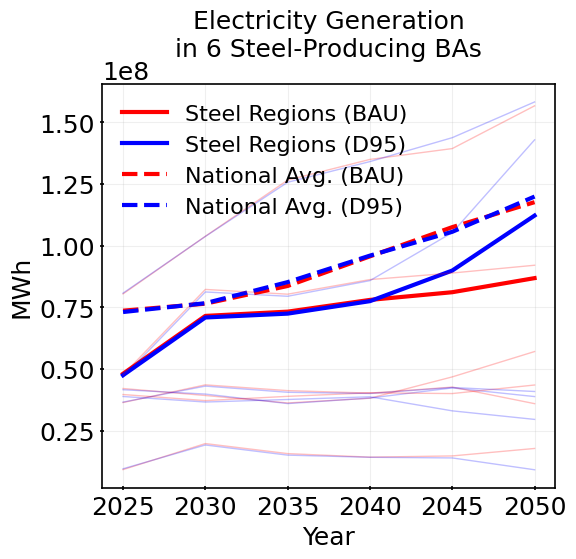

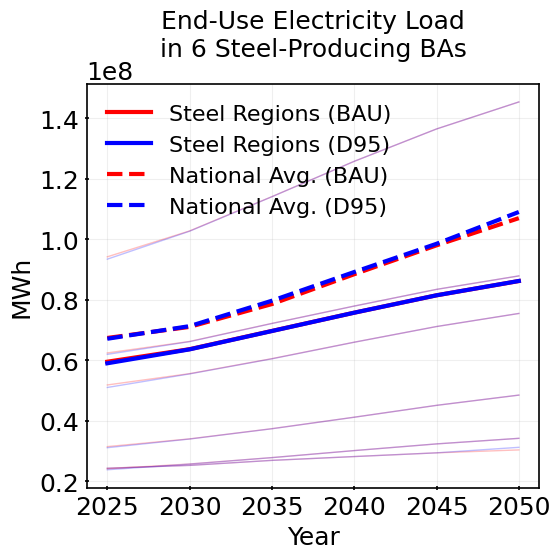

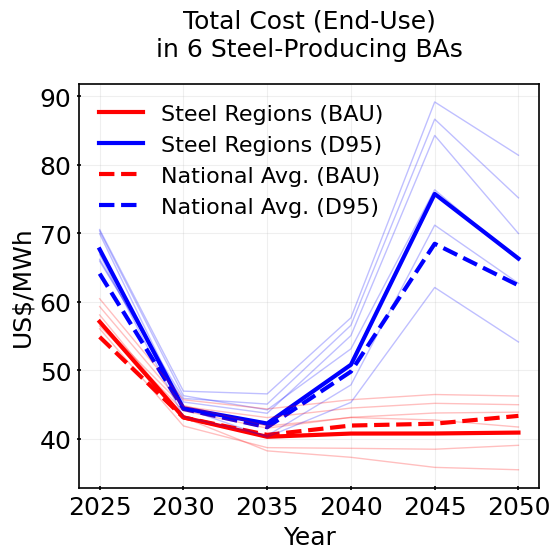

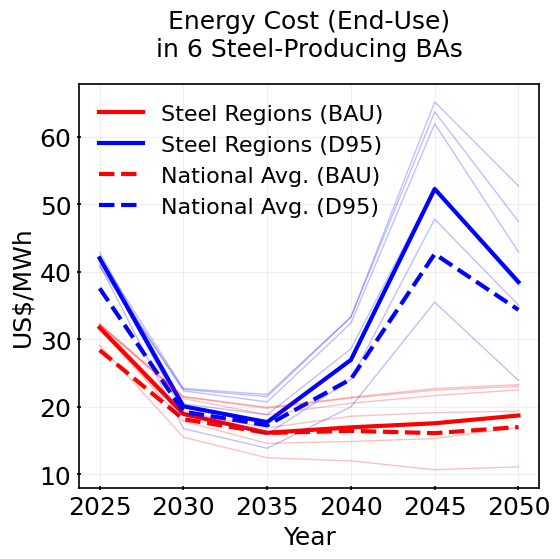

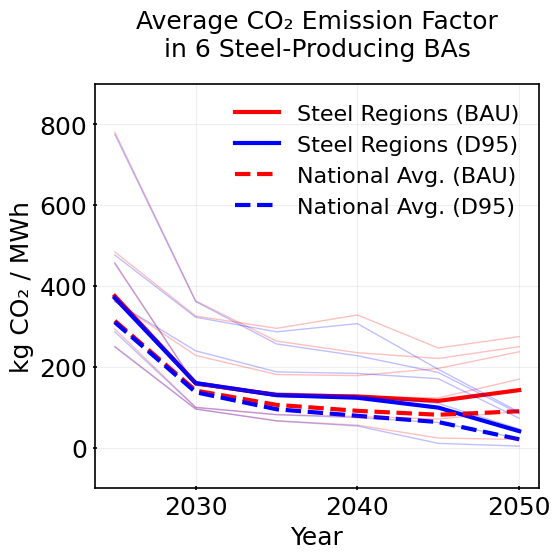

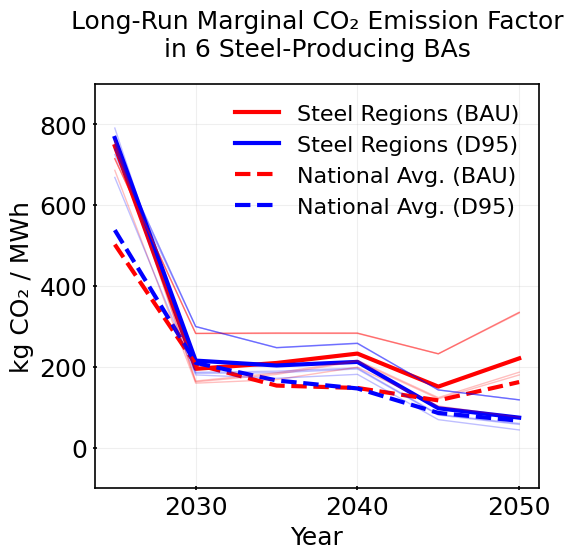

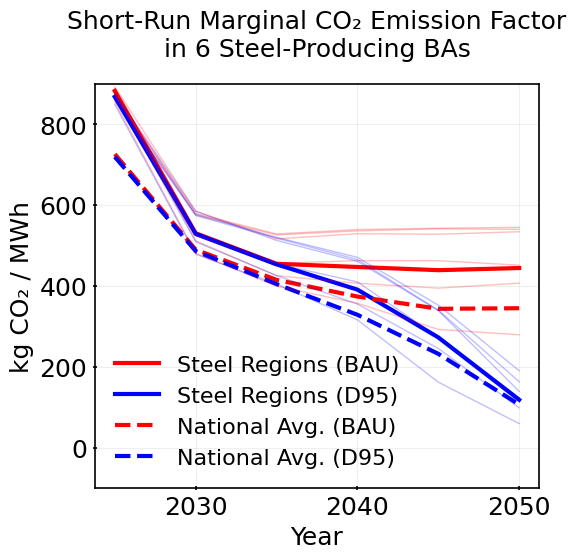

' # ===== RIGHT PANEL =====\nax = axes[1]\nax.plot(df_BAU_avg[\'t\'], df_BAU_avg[\'lrmer_co2e\'],\n        label="Steel Regions (BAU)", color="red", linewidth=5)\nax.plot(df_D95_avg[\'t\'], df_D95_avg[\'lrmer_co2e\'],\n        label="Steel Regions (95% by 2050)", color="blue", linewidth=5)\n\nax.plot(df_BAU_natavg[\'t\'], df_BAU_natavg[\'lrmer_co2e\'],\n        label="National Avg. (BAU)", color="red", linestyle=\'--\', linewidth=3)\nax.plot(df_D95_natavg[\'t\'], df_D95_natavg[\'lrmer_co2e\'],\n        label="National Avg. (95% by 2050)", color="blue", linestyle=\'--\', linewidth=3)\n\nax.set_title("Long-Run Marginal Scope 2 CO₂ EF of \nin 12 Steel-Producing BAs (kg/MWh)")\nax.set_ylabel("Emission Factor (kg/MWh)")\nax.set_ylim(-100, 900)\nax.legend(frameon=False) '

In [4]:
# --- Global plot style ---
mpl.rcParams.update({
    'font.size': 20,            # base font size
    'axes.titlesize': 18,       # title font
    'axes.titlepad': 20,         # <-- adds space under title
    'axes.labelsize': 18,       # axis label font
    'xtick.labelsize': 18,      # x-tick font
    'ytick.labelsize': 18,      # y-tick font
    'legend.fontsize': 16,      # legend font
    'figure.titlesize': 20,     # overall figure title
    'lines.linewidth': 3,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.direction': 'inout',
    'ytick.direction': 'inout'
})

# --- Variables to plot ---
variables = [
    'generation', 'enduse_load', 'total_cost_enduse', 'energy_cost_enduse',
    'aer_load_co2e', 'lrmer_co2e', 'srmer_co2e'
]

# --- Title mappings for readability ---
titles = {
    'generation': 'Electricity Generation',
    'enduse_load': 'End-Use Electricity Load',
    'total_cost_enduse': 'Total Cost (End-Use)',
    'energy_cost_enduse': 'Energy Cost (End-Use)',
    'aer_load_co2e': 'Average CO₂ Emission Factor',
    'lrmer_co2e': 'Long-Run Marginal CO₂ Emission Factor',
    'srmer_co2e': 'Short-Run Marginal CO₂ Emission Factor'
}


# --- Units for y-axis ---
ylabels = {
    'generation': 'MWh',
    'enduse_load': 'MWh',
    'total_cost_enduse': 'US$/MWh',
    'energy_cost_enduse': 'US$/MWh',
    'aer_load_co2e': 'kg CO₂ / MWh',
    'lrmer_co2e': 'kg CO₂ / MWh',
    'srmer_co2e': 'kg CO₂ / MWh'
}

# --- Loop over all variables ---
for var in variables:
    fig, ax = plt.subplots(figsize=(6, 6))

    # --- Averages (Steel Regions vs. National) ---
    ax.plot(df_BAU_avg['t'], df_BAU_avg[var],
            label="Steel Regions (BAU)", color="red", linewidth=3)
    ax.plot(df_D95_avg['t'], df_D95_avg[var],
            label="Steel Regions (D95)", color="blue", linewidth=3)

    ax.plot(df_BAU_natavg['t'], df_BAU_natavg[var],
            label="National Avg. (BAU)", color="red", linestyle='--', linewidth=3)
    ax.plot(df_D95_natavg['t'], df_D95_natavg[var],
            label="National Avg. (D95)", color="blue", linestyle='--', linewidth=3)

    # --- Thin lines for each region ---
    for r in df_BAU['r'].unique():
        df_temp = df_BAU[df_BAU['r'] == r]
        df_temp2 = df_D95[df_D95['r'] == r]
        ax.plot(df_temp['t'], df_temp[var], color="red", alpha=0.25, linewidth=1)
        ax.plot(df_temp2['t'], df_temp2[var], color="blue", alpha=0.25, linewidth=1)

    # --- Labels and title ---
    title_text = titles.get(var, var)
    ax.set_title(f"{title_text}\nin 6 Steel-Producing BAs")
    ax.set_ylabel(ylabels.get(var, 'Value'))
    ax.set_xlabel("Year")
    ax.legend(frameon=False)
    ax.grid(alpha=0.2)

    # --- Optional: adjust y-axis limits for emission factors only ---
    if 'co2e' in var.lower():
        ax.set_ylim(-100, 900)

    # --- Final layout and show/save ---
    fig.tight_layout()
    plt.show()
    #fig.savefig(f"C:/Users/judec/Documents/CMU/Project 1/Final Figures/Cambium2023_trends_temporal/{var}.png", dpi=300, bbox_inches='tight')


""" # ===== RIGHT PANEL =====
ax = axes[1]
ax.plot(df_BAU_avg['t'], df_BAU_avg['lrmer_co2e'],
        label="Steel Regions (BAU)", color="red", linewidth=5)
ax.plot(df_D95_avg['t'], df_D95_avg['lrmer_co2e'],
        label="Steel Regions (95% by 2050)", color="blue", linewidth=5)

ax.plot(df_BAU_natavg['t'], df_BAU_natavg['lrmer_co2e'],
        label="National Avg. (BAU)", color="red", linestyle='--', linewidth=3)
ax.plot(df_D95_natavg['t'], df_D95_natavg['lrmer_co2e'],
        label="National Avg. (95% by 2050)", color="blue", linestyle='--', linewidth=3)

ax.set_title("Long-Run Marginal Scope 2 CO₂ EF of \nin 12 Steel-Producing BAs (kg/MWh)")
ax.set_ylabel("Emission Factor (kg/MWh)")
ax.set_ylim(-100, 900)
ax.legend(frameon=False) """


In [5]:
# store BA-level data

# Ensure year is a string column and strip spaces
df['t'] = df['t'].astype(str).str.strip()

years = ['2025', '2030', '2035', '2040', '2045', '2050']

# Dictionary to store results
camb = {}

for scenario in scenarios:
    scenario_df = df[df['scenario'] == scenario].copy()

    # Initialize merged dataframe with sourcelist
    camb23_merged = sourcelist.copy()

    for year in years:
        temp_df_filtered = scenario_df[scenario_df['t'] == year]


        # Rename columns to include scenario and year
        temp_df_filtered = temp_df_filtered.rename(
            columns={col: f"{year}_{col}_{scenario}" for col in temp_df_filtered.columns if col != 'r'}
        )

        # Merge with sourcelist
        camb23_merged = pd.merge(camb23_merged, temp_df_filtered, on='r', how='left')

    # Compute averages across all years for each category
    for category in ['generation', 'enduse_load', 'aer_load_co2e', 'lrmer_co2e', 'srmer_co2e', 'total_cost_enduse']:
        category_columns = [col for col in camb23_merged.columns if f"_{category}_" in col]
        camb23_merged[f"avg_{category}_{scenario}"] = camb23_merged[category_columns].mean(axis=1)


    # Sort the columns from index 16 onwards (by variable and then by year)
    columns_first_part = camb23_merged.columns[:15]
    columns_to_sort = camb23_merged.columns[15:]
    sorted_columns = sorted(columns_to_sort, key=lambda x: (x.split("_")[1], x.split("_")[0]))
    
    # Combine the first 15 columns with the sorted ones
    camb23_merged = camb23_merged[columns_first_part.tolist() + sorted_columns]

    # Store final sorted dataframe
    #camb[scenario] = camb23_merged
    #camb[scenario].to_csv(dir + f"data_processed/camb_data_{scenario}_byBA.csv", index=False)

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\52347508.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\52347508.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\52347508.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


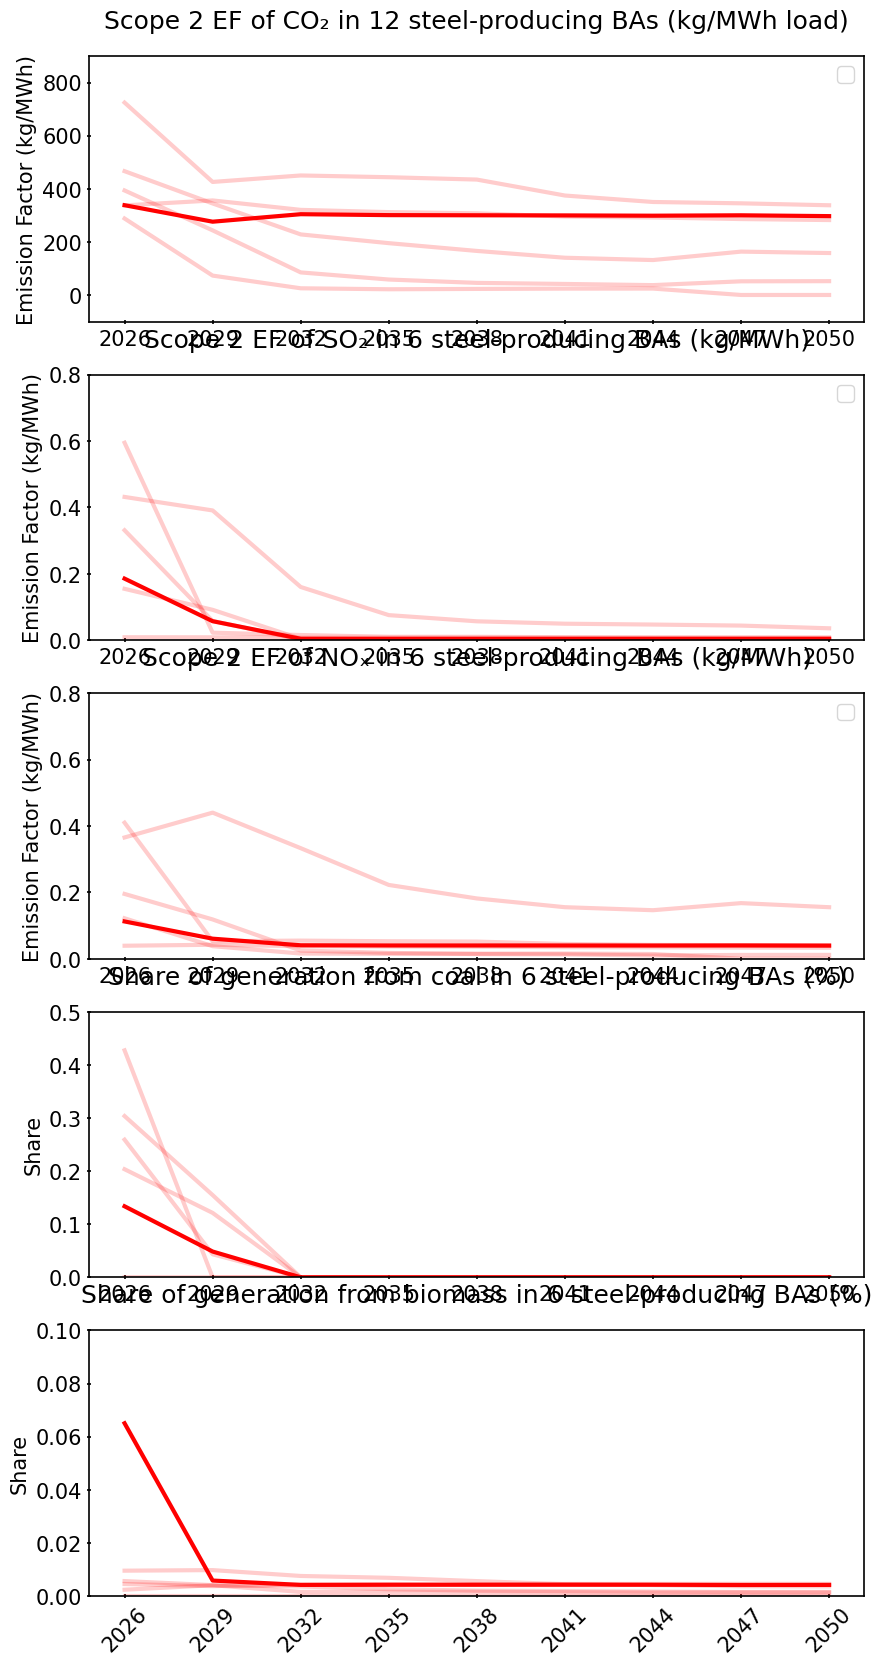

In [6]:
# process std scenario data (by BA)

filename = dir + "StdScen24_raw/StdScen24_annual_balancingAreas.csv"
df2_raw = pd.read_csv(filename, skiprows=3)  # skip header rows
df2 = df2_raw.copy()

# Filter only necessary scenarios and columns
df2['scenario'] = df2['scenario'].replace({'Mid_Case': 'BAU', 'Mid_Case_95by2050': 'D95'})

scenarios = ['BAU', 'D95']  # keep BAU only
df2 = df2[df2['scenario'].isin(scenarios)]

df2 = df2[['scenario', 'r', 't', 'load_enduse_MWh', 'coal_MWh', 'o-g-s_MWh',
           'gas_cc_MWh', 'gas_ct_MWh', 'bio_MWh', 'generation',
           'co2e_net_mt', 'so2_c_mt', 'nox_c_mt']]

# compute emission factors and fuel shares
df2['co2e_mt_perMWh'] = df2['co2e_net_mt'] / df2['generation']
df2['so2_mt_perMWh']  = df2['so2_c_mt']   / df2['generation']
df2['nox_mt_perMWh']  = df2['nox_c_mt']   / df2['generation']
df2['coal_share'] = df2['coal_MWh'] / df2['generation']
df2['gas_share']  = (df2['gas_cc_MWh'] + df2['gas_ct_MWh']) / df2['generation']
df2['oil_share']  = df2['o-g-s_MWh'] / df2['generation']
df2['bio_share']  = df2['bio_MWh']   / df2['generation']

# steel regions only (IIS sources)
sourcelist = sourcelist_raw[sourcelist_raw['source type'] == 'IIS']

df_BAU = df2[df2['scenario'] == 'BAU']
df_BAU = df_BAU[df_BAU['r'].isin(sourcelist['r'])]

# (Removed all average calculations/lines)

# ===== 3x font sizes =====
from matplotlib import rcParams
_scale = 1.5
rcParams.update({
    'font.size':        10 * _scale,
    'axes.labelsize':   10 * _scale,
    'axes.titlesize':   12 * _scale,
    'xtick.labelsize':  10 * _scale,
    'ytick.labelsize':  10 * _scale,
    'legend.fontsize':  10 * _scale,
})

# Plot Emission Factors over Time for Each Scenario
fig, axes = plt.subplots(5, 1, figsize=(10, 20), sharex=True)

# CO2 EF
plt.subplot(5, 1, 1)
plt.title("Scope 2 EF of CO₂ in 12 steel-producing BAs (kg/MWh load)")
plt.ylabel("Emission Factor (kg/MWh)")
plt.ylim(-100, 900)
# keep BAU years on x-axis (no averages)
plt.xticks(sorted(df_BAU['t'].unique()), rotation=45)
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.legend()

# SO2 EF
plt.subplot(5, 1, 2)
plt.title("Scope 2 EF of SO₂ in 6 steel-producing BAs (kg/MWh)")
plt.ylabel("Emission Factor (kg/MWh)")
plt.ylim(0, 0.8)
plt.xticks(sorted(df_BAU['t'].unique()), rotation=45)
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.legend()

# NOx EF
plt.subplot(5, 1, 3)
plt.title("Scope 2 EF of NOₓ in 6 steel-producing BAs (kg/MWh)")
plt.ylabel("Emission Factor (kg/MWh)")
plt.xticks(sorted(df_BAU['t'].unique()), rotation=45)
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.legend()

# Coal share
plt.subplot(5, 1, 4)
plt.title("Share of generation from coal in 6 steel-producing BAs (%)")
plt.ylabel("Share")
plt.xticks(sorted(df_BAU['t'].unique()), rotation=45)
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

# Biomass share
plt.subplot(5, 1, 5)
plt.title("Share of generation from biomass in 6 steel-producing BAs (%)")
plt.ylabel("Share")
plt.xticks(sorted(df_BAU['t'].unique()), rotation=45)
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

# Plot lines for each region (BAU only; D95 removed)
for r in df_BAU['r'].unique():
    df_temp = df_BAU[df_BAU['r'] == r]

    # Full opacity for p115 (Wayne, MI), otherwise 0.2
    alpha_val = 1.0 if r == 'p115' else 0.2

    plt.subplot(5, 1, 1)
    plt.plot(df_temp['t'], df_temp['co2e_mt_perMWh'] * 1000, label="", color="red", alpha=alpha_val)

    plt.subplot(5, 1, 2)
    plt.plot(df_temp['t'], df_temp['so2_mt_perMWh'] * 1000, label="", color="red", alpha=alpha_val)

    plt.subplot(5, 1, 3)
    plt.plot(df_temp['t'], df_temp['nox_mt_perMWh'] * 1000, label="", color="red", alpha=alpha_val)
    plt.ylim(0, 0.8)

    plt.subplot(5, 1, 4)
    plt.plot(df_temp['t'], df_temp['coal_share'], label="", color="red", alpha=alpha_val)
    plt.ylim(0, 0.5)

    plt.subplot(5, 1, 5)
    plt.plot(df_temp['t'], df_temp['bio_share'], label="", color="red", alpha=alpha_val)
    plt.ylim(0, 0.1)

plt.show()


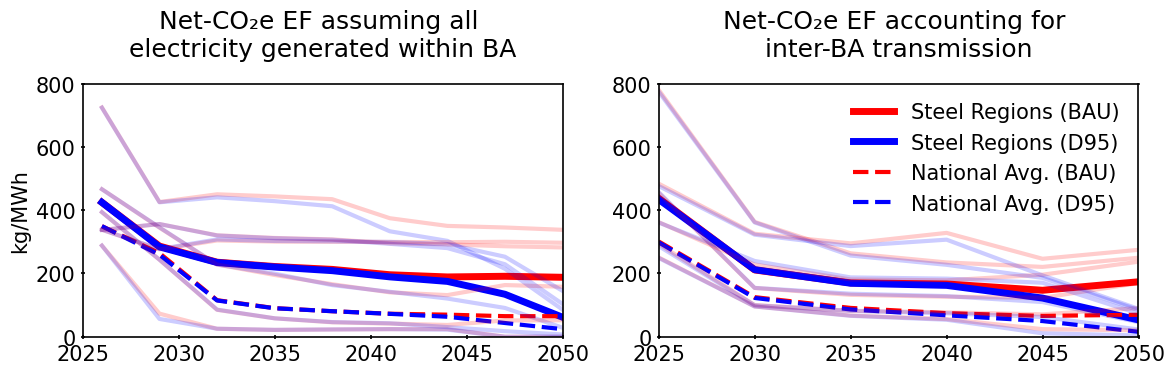

In [47]:
# COMPARE AVG CO2 EF FROM STDSCEN WITH AER_LOAD EF FROM CAMBIUM

# CAMBIUM
df_camb = df3_raw.copy()

# Filter only necessary scenarios
df_camb['scenario'] = df_camb['scenario'].replace({'MidCase': 'BAU', 'Decarb95by2050': 'D95'})

scenarios = ['BAU', 'D95']

df_camb = df_camb[df_camb['scenario'].isin(scenarios)]

# Select only relevant columns before merging
df_camb = df_camb[['scenario', 'r', 't', 'generation', 'enduse_load', 'aer_load_co2e', 'lrmer_co2e', 'srmer_co2e']]

# national and steel region averages
df_camb_BAU = df_camb[df_camb['scenario'] == 'BAU']
df_camb_BAU_natavg = df_camb_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_camb_BAU = df_camb_BAU[df_camb_BAU['r'].isin(sourcelist['r'])]
df_camb_BAU_avg = df_camb_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_camb_D95 = df_camb[df_camb['scenario'] == 'D95']
df_camb_D95_natavg = df_camb_D95.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_camb_D95 = df_camb_D95[df_camb_D95['r'].isin(sourcelist['r'])]
df_camb_D95_avg = df_camb_D95.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()


# process std scenario data (by BA)
sourcelist = sourcelist_raw[sourcelist_raw['source type'] == 'IIS']

# national and steel region averages
df_BAU = df2[df2['scenario'] == 'BAU']
df_BAU_natavg = df_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_BAU = df_BAU[df_BAU['r'].isin(sourcelist['r'])]
df_BAU_avg = df_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_D95 = df2[df2['scenario'] == 'D95']
df_D95_natavg = df_D95.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_D95 = df_D95[df_D95['r'].isin(sourcelist['r'])]
df_D95_avg = df_D95.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()


# Plot Emission Factors over Time for Each Scenario
fig, axes = plt.subplots(1,2, figsize=(12, 4), sharex=True)

# avg ERs from stdscen (DOESNT ACCOUNT FOR INTER BA TRANSMISSION - WHY?? )
plt.subplot(1,2,1)
plt.plot(df_BAU_avg['t'], df_BAU_avg['co2e_mt_perMWh']*1000, label = "Steel Regions (BAU)", color= "red", linewidth=5)
plt.plot(df_D95_avg['t'], df_D95_avg['co2e_mt_perMWh']*1000, label = "Steel Regions (D95)", color= "blue", linewidth=5)

plt.plot(df_BAU_natavg['t'], df_BAU_natavg['co2e_mt_perMWh']*1000, label = "National Avg. (BAU)", color= "red", linewidth=3, linestyle='--')
plt.plot(df_D95_natavg['t'], df_D95_natavg['co2e_mt_perMWh']*1000, label = "National Avg. (D95)", color= "blue", linewidth=3,  linestyle='--')

plt.title("Net-CO₂e EF assuming all \nelectricity generated within BA")
plt.ylabel("kg/MWh")
plt.ylim(0,800)
plt.xlim(2025,2050)

#plt.legend()

# long run ERs from cambium 2023 (ACCOUNTS FOR INTER BA TRANSMISSION - WHY??)
plt.subplot(1,2,2)
plt.plot(df_camb_BAU_avg['t'], df_camb_BAU_avg['aer_load_co2e'], label = "Steel Regions (BAU)", color= "red", linewidth=5)
plt.plot(df_camb_D95_avg['t'], df_camb_D95_avg['aer_load_co2e'], label = "Steel Regions (D95)", color= "blue", linewidth=5)

plt.plot(df_camb_BAU_natavg['t'], df_camb_BAU_natavg['aer_load_co2e'], label = "National Avg. (BAU)", color= "red", linewidth=3, linestyle='--')
plt.plot(df_camb_D95_natavg['t'], df_camb_D95_natavg['aer_load_co2e'], label = "National Avg. (D95)", color= "blue", linewidth=3,  linestyle='--')


plt.title("Net-CO₂e EF accounting for \ninter-BA transmission")
plt.ylim(0,800)
plt.xlim(2025,2050)
plt.legend(frameon=False)


# plot lines for each region

for r in df_BAU['r'].unique():
    
    df_temp = df_BAU[df_BAU['r'] == r]
    df_temp2 = df_D95[df_D95['r'] == r]
    df_camb_temp = df_camb_BAU[df_camb_BAU['r']==r]
    df_camb_temp2 = df_camb_D95[df_camb_D95['r']==r]

    plt.subplot(1,2,1)
    plt.plot(df_temp['t'], df_temp['co2e_mt_perMWh']*1000, label = "", color= "red", alpha = 0.2)
    plt.plot(df_temp2['t'], df_temp2['co2e_mt_perMWh']*1000, label = "", color= "blue", alpha = 0.2)

    #print(df_camb_temp2['lrmer_co2e'])
    plt.subplot(1,2,2)
    plt.plot(df_camb_temp['t'], df_camb_temp['aer_load_co2e'], label = "", color= "red", alpha = 0.2)
    plt.plot(df_camb_temp2['t'], df_camb_temp2['aer_load_co2e'], label = "", color= "blue", alpha = 0.2)


# --- Final layout and show/save ---
fig.tight_layout()
plt.show()
fig.savefig(f"C:/Users/judec/Documents/CMU/Project 1/Final Figures/Cambium2023_trends_temporal/interBA_comparison.png", dpi=300, bbox_inches='tight')


'     plt.subplot(1,2,2)\n    plt.plot(df_camb_temp[\'t\'], df_camb_temp[\'lrmer_co2e\'], label = "", color= "red", alpha = 0.2)\n    plt.plot(df_camb_temp2[\'t\'], df_camb_temp2[\'lrmer_co2e\'], label = "", color= "blue", alpha = 0.2)\n '

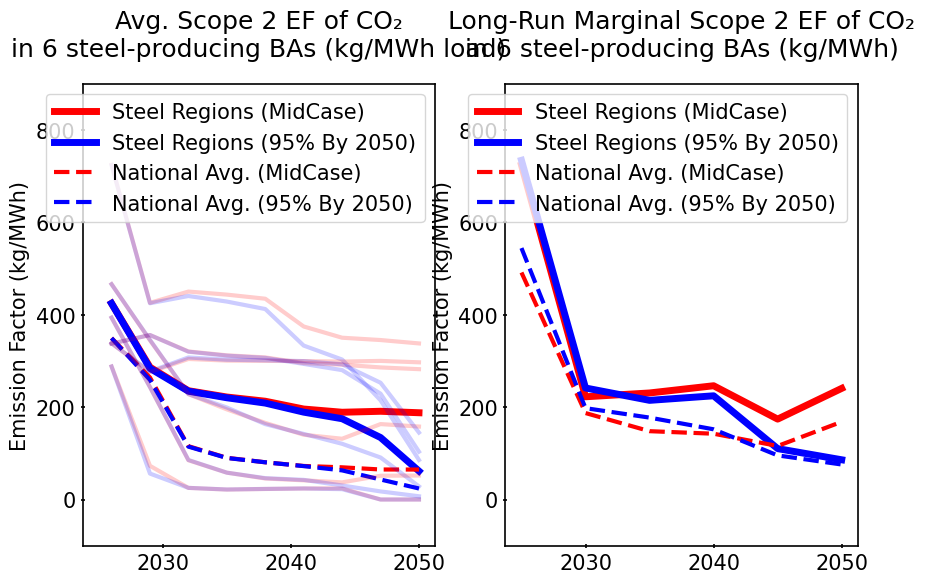

In [48]:
# COMPARE AVG CO2 EF FROM STDSCEN WITH LRMER FROM CAMBIUM

# CAMBIUM
df_camb = df3_raw.copy()

# Filter only necessary scenarios
df_camb['scenario'] = df_camb['scenario'].replace({'MidCase': 'BAU', 'Decarb95by2050': 'D95'})

scenarios = ['BAU', 'D95']

df_camb = df_camb[df_camb['scenario'].isin(scenarios)]

# Select only relevant columns before merging
df_camb = df_camb[['scenario', 'r', 't', 'generation', 'enduse_load', 'aer_load_co2e', 'lrmer_co2e', 'srmer_co2e']]

# national and steel region averages
df_camb_BAU = df_camb[df_camb['scenario'] == 'BAU']
df_camb_BAU_natavg = df_camb_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_camb_BAU = df_camb_BAU[df_camb_BAU['r'].isin(sourcelist['r'])]
df_camb_BAU_avg = df_camb_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_camb_D95 = df_camb[df_camb['scenario'] == 'D95']
df_camb_D95_natavg = df_camb_D95.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_camb_D95 = df_camb_D95[df_camb_D95['r'].isin(sourcelist['r'])]
df_camb_D95_avg = df_camb_D95.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()


# process std scenario data (by BA)

sourcelist = sourcelist[sourcelist['source type'] == 'IIS']

# national and steel region averages
df_BAU = df2[df2['scenario'] == 'BAU']
df_BAU_natavg = df_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_BAU = df_BAU[df_BAU['r'].isin(sourcelist['r'])]
df_BAU_avg = df_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_D95 = df2[df2['scenario'] == 'D95']
df_D95_natavg = df_D95.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_D95 = df_D95[df_D95['r'].isin(sourcelist['r'])]
df_D95_avg = df_D95.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()



# Plot Emission Factors over Time for Each Scenario
fig, axes = plt.subplots(1,2, figsize=(10, 6), sharex=True)

# avg ERs from stdscen
plt.subplot(1,2,1)
plt.plot(df_BAU_avg['t'], df_BAU_avg['co2e_mt_perMWh']*1000, label = "Steel Regions (MidCase)", color= "red", linewidth=5)
plt.plot(df_D95_avg['t'], df_D95_avg['co2e_mt_perMWh']*1000, label = "Steel Regions (95% By 2050)", color= "blue", linewidth=5)

plt.plot(df_BAU_natavg['t'], df_BAU_natavg['co2e_mt_perMWh']*1000, label = "National Avg. (MidCase)", color= "red", linewidth=3, linestyle='--')
plt.plot(df_D95_natavg['t'], df_D95_natavg['co2e_mt_perMWh']*1000, label = "National Avg. (95% By 2050)", color= "blue", linewidth=3,  linestyle='--')

plt.title("Avg. Scope 2 EF of CO₂\nin 6 steel-producing BAs (kg/MWh load)")
plt.ylabel("Emission Factor (kg/MWh)")
plt.ylim(-100,900)
plt.legend()

# long run ERs
plt.subplot(1,2,2)
plt.plot(df_camb_BAU_avg['t'], df_camb_BAU_avg['lrmer_co2e'], label = "Steel Regions (MidCase)", color= "red", linewidth=5)
plt.plot(df_camb_D95_avg['t'], df_camb_D95_avg['lrmer_co2e'], label = "Steel Regions (95% By 2050)", color= "blue", linewidth=5)

plt.plot(df_camb_BAU_natavg['t'], df_camb_BAU_natavg['lrmer_co2e'], label = "National Avg. (MidCase)", color= "red", linewidth=3, linestyle='--')
plt.plot(df_camb_D95_natavg['t'], df_camb_D95_natavg['lrmer_co2e'], label = "National Avg. (95% By 2050)", color= "blue", linewidth=3,  linestyle='--')


plt.title("Long-Run Marginal Scope 2 EF of CO₂\nin 6 steel-producing BAs (kg/MWh)")
plt.ylabel("Emission Factor (kg/MWh)")
plt.ylim(-100,900)
plt.legend()


# plot lines for each region

for r in df_BAU['r'].unique():
    
    df_temp = df_BAU[df_BAU['r'] == r]
    df_temp2 = df_D95[df_D95['r'] == r]

    plt.subplot(1,2,1)
    plt.plot(df_temp['t'], df_temp['co2e_mt_perMWh']*1000, label = "", color= "red", alpha = 0.2)
    plt.plot(df_temp2['t'], df_temp2['co2e_mt_perMWh']*1000, label = "", color= "blue", alpha = 0.2)

    #print(df_camb_temp2['lrmer_co2e'])
"""     plt.subplot(1,2,2)
    plt.plot(df_camb_temp['t'], df_camb_temp['lrmer_co2e'], label = "", color= "red", alpha = 0.2)
    plt.plot(df_camb_temp2['t'], df_camb_temp2['lrmer_co2e'], label = "", color= "blue", alpha = 0.2)
 """




KeyError: 'load_enduse_MWh'

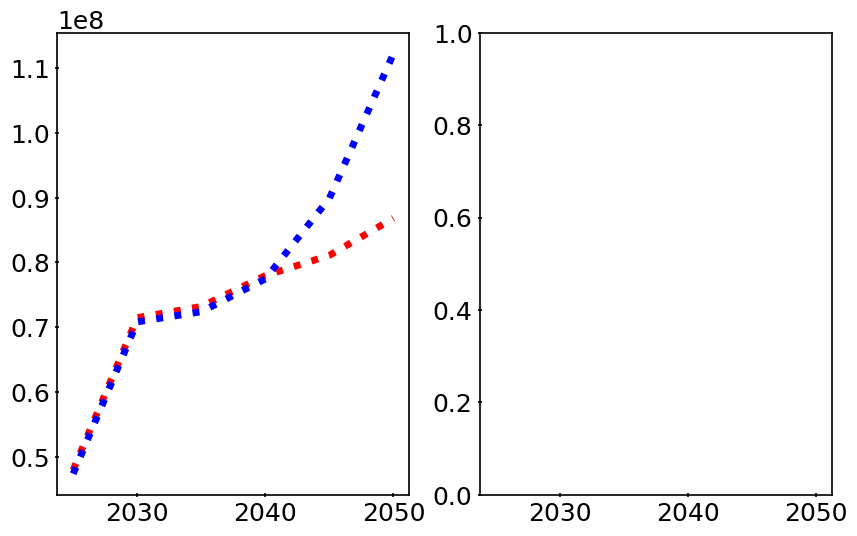

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10, 6), sharex=True)

plt.subplot(1,2,1)
plt.plot(df_BAU_avg['t'], df_BAU_avg['generation'], label = "generation - Mid", linestyle = "dotted", color= "red", linewidth=5)
plt.plot(df_D95_avg['t'], df_D95_avg['generation'], label = "generation - D95", linestyle = "dotted", color= "blue", linewidth=5)


plt.plot(df_BAU_avg['t'], df_BAU_avg['load_enduse_MWh'], label = "enduse load - Mid",  color= "red", linewidth=5)
plt.plot(df_D95_avg['t'], df_D95_avg['load_enduse_MWh'], label = "enduse load - D95", color= "blue", linewidth=5)

plt.title("Enduse load vs. generation for steel regions")
plt.ylabel("Electricity (MWh)")
#plt.ylim(-100,900)
plt.legend()

plt.subplot(1,2,2)

df_D95['ratio'] = df_D95['load_enduse_MWh']/df_D95['generation']
df_BAU['ratio'] = df_BAU['load_enduse_MWh']/df_BAU['generation']

for r in df_BAU['r'].unique():
    
    df_temp = df_BAU[df_BAU['r'] == r]

    df_temp2 = df_D95[df_D95['r'] == r]

    plt.plot(df_temp['t'], df_temp['load_enduse_MWh']/df_temp['generation'], label = "load/gen - Mid", color= "red", alpha = 0.2)
    #plt.plot(df_temp['t'], df_temp['generation'], label = "", color= "red", linestyle = "--",alpha = 0.2)

    plt.plot(df_temp2['t'], df_temp2['load_enduse_MWh']/df_temp2['generation'], label = "load/gen - D95", color= "blue", alpha = 0.2)
    #plt.plot(df_temp2['t'], df_temp2['generation'], label = "", color= "blue", linestyle = "--", alpha = 0.2)


plt.title("Enduse load to generation ratio for 6 steel BAs")

    #print(df_camb_temp2['lrmer_co2e'])
"""     plt.subplot(1,2,2)
    plt.plot(df_camb_temp['t'], df_camb_temp['lrmer_co2e'], label = "", color= "red", alpha = 0.2)
    plt.plot(df_camb_temp2['t'], df_camb_temp2['lrmer_co2e'], label = "", color= "blue", alpha = 0.2)
 """



START HERE

In [8]:
# PIVOT YEARS AS SEPARATE COLUMNS TO GET AVG EF ACROSS PLANT LIFE (STD SCENARIO)


scenarios = ['BAU', 'D95']

# load files
filename = dir + "emi_sources/condensed_sourcelist.csv"
sourcelist = pd.read_csv(filename)
sourcelist = sourcelist.rename(columns={'Cambium GEA': 'gea'})
sourcelist = sourcelist.rename(columns={'ReEDS BA': 'r'})

filename = dir + "StdScen24_raw/StdScen24_annual_balancingAreas.csv"
df2_raw = pd.read_csv(filename, skiprows=3) #skip header
df2 = df2_raw.copy()

filename = dir + "Cambium23_raw/Cambium23_allScenarios_annual_balancingArea.csv"
df3 = pd.read_csv(filename, skiprows=5) #skip header

filename = "C:/Users/judec/Documents/CMU/Project 1/Scope 2 Emissions/GREET_EFs_by_fuel_and_state_SUMMARY_g_kWh.csv"
efs = pd.read_csv(filename)

# Filter only necessary scenarios and columns
df2['scenario'] = df2['scenario'].replace({'Mid_Case': 'BAU', 'Mid_Case_95by2050': 'D95'})
df2 = df2[df2['scenario'].isin(scenarios)]

df3['scenario'] = df3['scenario'].replace({'MidCase': 'BAU', 'Decarb95by2050': 'D95'})
df3 = df3[df3['scenario'].isin(scenarios)]

# select relevant variables

df3 = df3[['scenario', 'r', 't', 'total_cost_enduse']] # total enduse cost, $/MWh

df2 = df2[['scenario', 'r', 't', 'load_enduse_MWh', 'generation', 'co2e_net_mt', 'so2_c_mt', 'nox_c_mt',
            'o-g-s_MWh', 'coal_MWh', 'gas_cc_MWh', 'gas_ct_MWh', 'bio_MWh']]

# compute relevant variables
df2['co2e_mt_perMWh'] = df2['co2e_net_mt']/df2['generation']
df2['so2_mt_perMWh'] = df2['so2_c_mt']/df2['generation']
df2['nox_mt_perMWh'] = df2['nox_c_mt']/df2['generation']
df2['fossil_share_perMWh'] = (df2['o-g-s_MWh'] + df2['coal_MWh'] + df2['gas_cc_MWh'] + df2['gas_ct_MWh'])/df2['generation']

# Dictionary to store results
stdscen = {}
cambium = {}

stdscen_allBAs = {}
cambium_allBAs = {}

for scenario in scenarios:
    scenario_df2 = df2[df2['scenario'] == scenario].copy()
    scenario_df3 = df3[df3['scenario'] == scenario].copy()

    # Initialize merged dataframe with sourcelist

    # keep only list of unique (132) BAS
    ss24 = scenario_df2.drop_duplicates(subset='r')[['scenario', 'r']].copy()
    camb23 = scenario_df3.drop_duplicates(subset='r')[['scenario', 'r']].copy()

    # keep only BAs where IIS/coke plants are located
    final_merged = sourcelist.copy()

    # 3-year interval for std scenario data (all variables except enduse cost)
    years = np.arange(2026, 2051, 3)
    for year in years:
        temp_df2_filtered = scenario_df2[scenario_df2['t'] == year]

        # Rename columns to include year
        temp_df2_filtered = temp_df2_filtered.rename(
            columns={col: f"{year}_{col}" for col in temp_df2_filtered.columns if col not in ['scenario', 'r', 't']}
        )

        temp_df2_filtered.drop(columns=['scenario', 't'], inplace=True)

        # Merge with sourcelist
        ss24 = pd.merge(ss24, temp_df2_filtered, on='r', how='left')

    # 5-year interval for Cambium data (enduse cost)
    years = np.arange(2025, 2051, 5)
    for year in years:
        temp_df3_filtered = scenario_df3[scenario_df3['t'] == year]

        # Rename columns to include year
        temp_df3_filtered = temp_df3_filtered.rename(
            columns={col: f"{year}_{col}" for col in temp_df3_filtered.columns if col not in ['scenario', 'r', 't']}
        )

        temp_df3_filtered.drop(columns=['scenario', 't'], inplace=True)

        # Merge with sourcelist
        camb23 = pd.merge(camb23, temp_df3_filtered, on='r', how='left')

    # USE WEIGHTED AVERAGE TO EXTEND 2050 EFS TO 2066 TO REFLECT 40Y PLANT LIFE FROM 2026 TO 2066

    # FOR STD SCENARIO DATA:
    # weights: 2026: 3, 2029: 3 ... 2047:3, 2050: 2066 - 2050 = 16 [2050 to 2062 x3y each, 2065x2y]
    # Compute weighted averages across all years for each category

    for category in ['load_enduse_MWh', 'generation', 'co2e_mt_perMWh', 'so2_mt_perMWh', 'nox_mt_perMWh']:
        category_columns = [col for col in ss24.columns if f"_{category}" in col and col[:4].isdigit()]
        
        # Weight
        weights = [16 if col.startswith("2050") else 3 for col in category_columns]

        # Ensure matching DataFrame shape
        weighted_sum = (ss24[category_columns].multiply(weights)).sum(axis=1)
        total_weights = sum(weights)

        ss24[f"wavg_{category}"] = weighted_sum / total_weights

    
    # FOR CAMBIUM DATA:
    # weights: 2025: 2030 - 2026 = 4, 2030: 5 ... 2045:5, 2050: 2066 - 2050 = 16 [2050 to 2062 x3y each, 2065x2y]
    # Compute weighted averages across all years for each category

    for category in ['total_cost_enduse', 'load_enduse_MWh', 'generation', 'co2e_mt_perMWh', 'so2_mt_perMWh', 'nox_mt_perMWh']:
        category_columns = [col for col in camb23.columns if f"_{category}" in col and col[:4].isdigit()]
        
        # Weight
        
        weights = [
        16 if col.startswith("2050") else
        4 if col.startswith("2025") else
        5
        for col in category_columns
        ]

        # Ensure matching DataFrame shape
        weighted_sum = (camb23[category_columns].multiply(weights)).sum(axis=1)
        total_weights = sum(weights)

        camb23[f"wavg_{category}"] = weighted_sum / total_weights

    # keep only wavg LCOE
    camb23 = camb23[['scenario', 'r', 'wavg_total_cost_enduse']]


    #merge with sourcelist
    final_merged = pd.merge(final_merged, ss24, on='r', how='left')

    # SORT final_merged
    # Sort the columns from #18 onwards (by variable and then by year)
    columns_first_part = final_merged.columns[:17]
    columns_to_sort = final_merged.columns[17:]
    sorted_columns = sorted(columns_to_sort, key=lambda x: (x.split("_")[1], x.split("_")[0]))

    # Combine the first 16 columns with the sorted ones
    final_merged = final_merged[columns_first_part.tolist() + sorted_columns]

    # merge cambium variable (enduse cost) into very end 
    final_merged = pd.merge(final_merged, camb23, on='r', how='left')

    # SORT SS24
    # Sort the columns from #3 onwards (by variable and then by year)
    columns_first_part2 = ss24.columns[:2]
    columns_to_sort2 = ss24.columns[2:]
    sorted_columns2 = sorted(columns_to_sort2, key=lambda x: (x.split("_")[1], x.split("_")[0]))

    # Combine the first 2 columns with the sorted ones
    ss24 = ss24[columns_first_part2.tolist() + sorted_columns2]

    # merge cambium variable (enduse cost) into very end 
    ss24 = pd.merge(ss24, camb23, on='r', how='left')

    # Store final sorted dataframe
    stdscen[scenario] = final_merged
    stdscen_allBAs[scenario] = ss24

    #stdscen_allBAs[scenario].to_csv(dir + f"data_processed/std_data_{scenario}_ALL_BAs.csv", index=False)
    #stdscen[scenario].to_csv(dir + f"data_processed/std_data_{scenario}.csv", index=False)

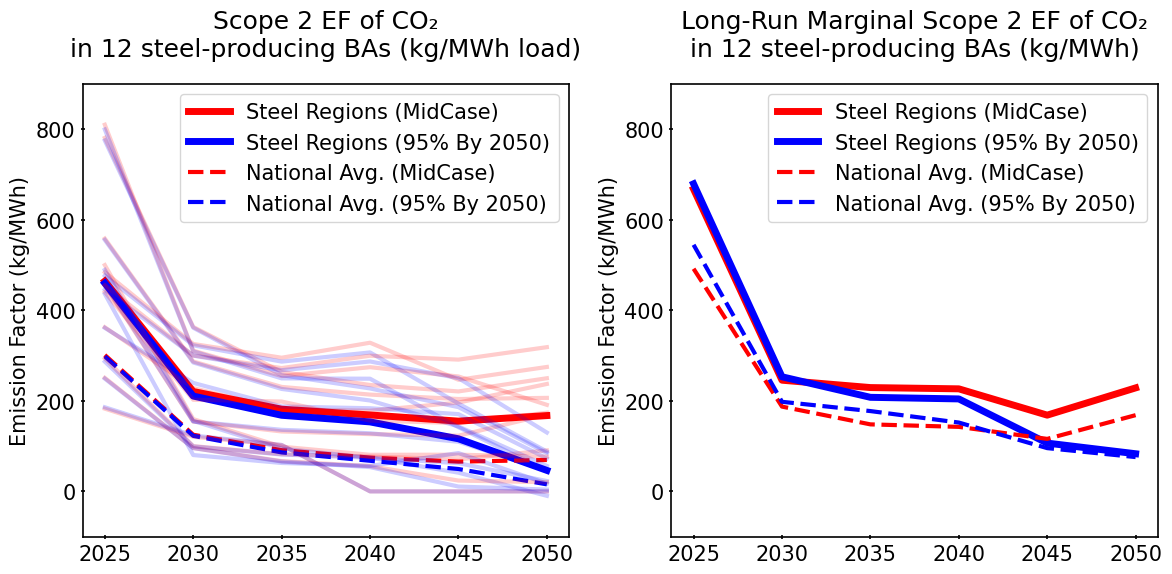

In [10]:
# process cambium data (by BA)

df = df3_raw.copy()

# Filter only necessary scenarios
df['scenario'] = df['scenario'].replace({'MidCase': 'BAU', 'Decarb95by2050': 'D95'})

scenarios = ['BAU', 'D95']

df = df[df['scenario'].isin(scenarios)]

# Select only relevant columns before merging
df = df[['scenario', 'r', 't', 'generation', 'enduse_load', 'aer_load_co2e', 'lrmer_co2e', 'srmer_co2e']]

# national and steel region averages
df_BAU = df[df['scenario'] == 'BAU']
df_BAU_natavg = df_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_BAU = df_BAU[df_BAU['r'].isin(sourcelist['r'])]
df_BAU_avg = df_BAU.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_D95 = df[df['scenario'] == 'D95']
df_D95_natavg = df_D95.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()

df_D95 = df_D95[df_D95['r'].isin(sourcelist['r'])]
df_D95_avg = df_D95.drop(columns=['scenario', 'r']).groupby('t', as_index=False).mean()


# Plot Emission Factors over Time for Each Scenario
fig, axes = plt.subplots(1,2, figsize=(12, 6), sharex=True)

# plot all-region averages
plt.subplot(1,2,1)
plt.plot(df_BAU_avg['t'], df_BAU_avg['aer_load_co2e'], label = "Steel Regions (MidCase)", color= "red", linewidth=5)
plt.plot(df_D95_avg['t'], df_D95_avg['aer_load_co2e'], label = "Steel Regions (95% By 2050)", color= "blue", linewidth=5)

plt.plot(df_BAU_natavg['t'], df_BAU_natavg['aer_load_co2e'], label = "National Avg. (MidCase)", color= "red", linewidth=3, linestyle='--')
plt.plot(df_D95_natavg['t'], df_D95_natavg['aer_load_co2e'], label = "National Avg. (95% By 2050)", color= "blue", linewidth=3,  linestyle='--')

plt.title("Scope 2 EF of CO₂\nin 12 steel-producing BAs (kg/MWh load)")
plt.ylabel("Emission Factor (kg/MWh)")
plt.ylim(-100,900)
plt.legend()

plt.subplot(1,2,2)
plt.plot(df_BAU_avg['t'], df_BAU_avg['lrmer_co2e'], label = "Steel Regions (MidCase)", color= "red", linewidth=5)
plt.plot(df_D95_avg['t'], df_D95_avg['lrmer_co2e'], label = "Steel Regions (95% By 2050)", color= "blue", linewidth=5)

plt.plot(df_BAU_natavg['t'], df_BAU_natavg['lrmer_co2e'], label = "National Avg. (MidCase)", color= "red", linewidth=3, linestyle='--')
plt.plot(df_D95_natavg['t'], df_D95_natavg['lrmer_co2e'], label = "National Avg. (95% By 2050)", color= "blue", linewidth=3,  linestyle='--')


plt.title("Long-Run Marginal Scope 2 EF of CO₂\nin 12 steel-producing BAs (kg/MWh)")
plt.ylabel("Emission Factor (kg/MWh)")
plt.ylim(-100,900)
plt.legend()


# plot lines for each region

for r in df_BAU['r'].unique():
    
    df_temp = df_BAU[df_BAU['r'] == r]
    df_temp2 = df_D95[df_D95['r'] == r]

    plt.subplot(1,2,1)
    plt.plot(df_temp['t'], df_temp['aer_load_co2e'], label = "", color= "red", alpha = 0.2)
    plt.plot(df_temp2['t'], df_temp2['aer_load_co2e'], label = "", color= "blue", alpha = 0.2)

    #print(df_temp2['lrmer_co2e'])
"""     plt.subplot(1,2,2)
    plt.plot(df_temp['t'], df_temp['lrmer_co2e'], label = "", color= "red", alpha = 0.2)
    plt.plot(df_temp2['t'], df_temp2['lrmer_co2e'], label = "", color= "blue", alpha = 0.2)
 """

plt.tight_layout()
plt.show()



    


C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


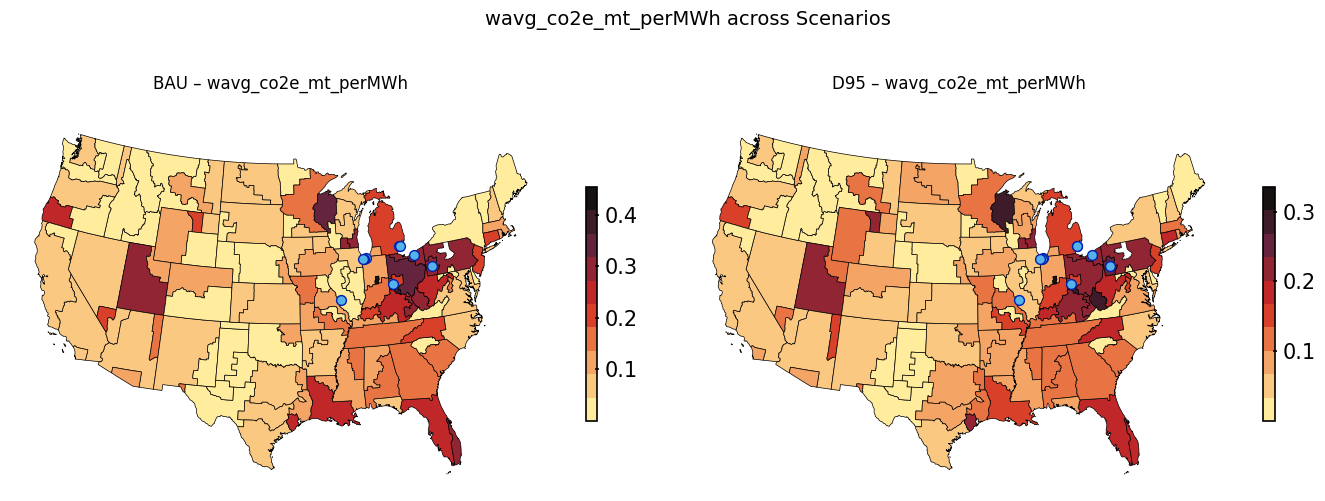

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


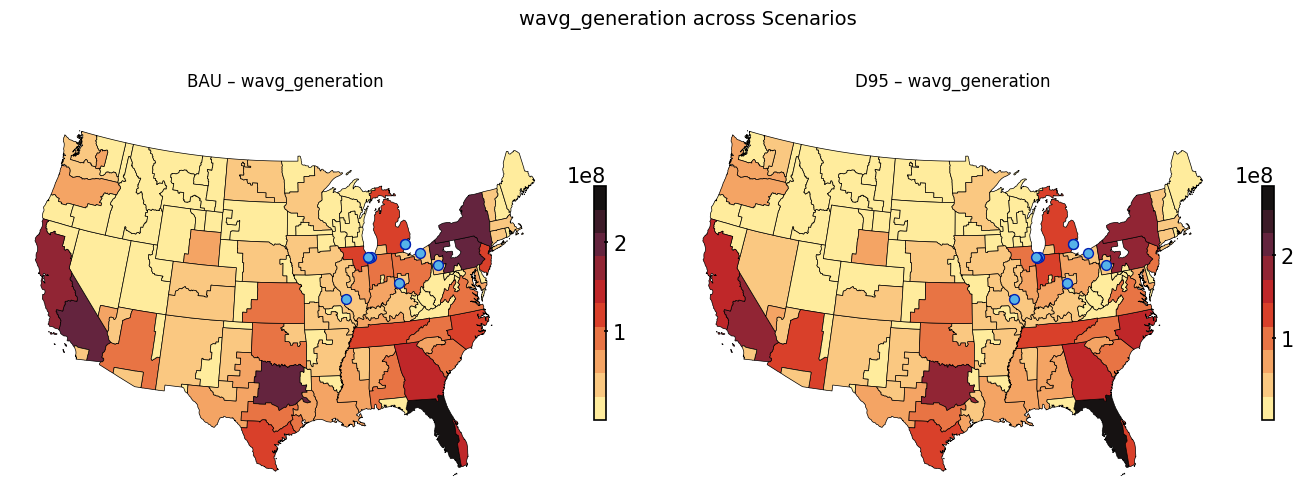

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


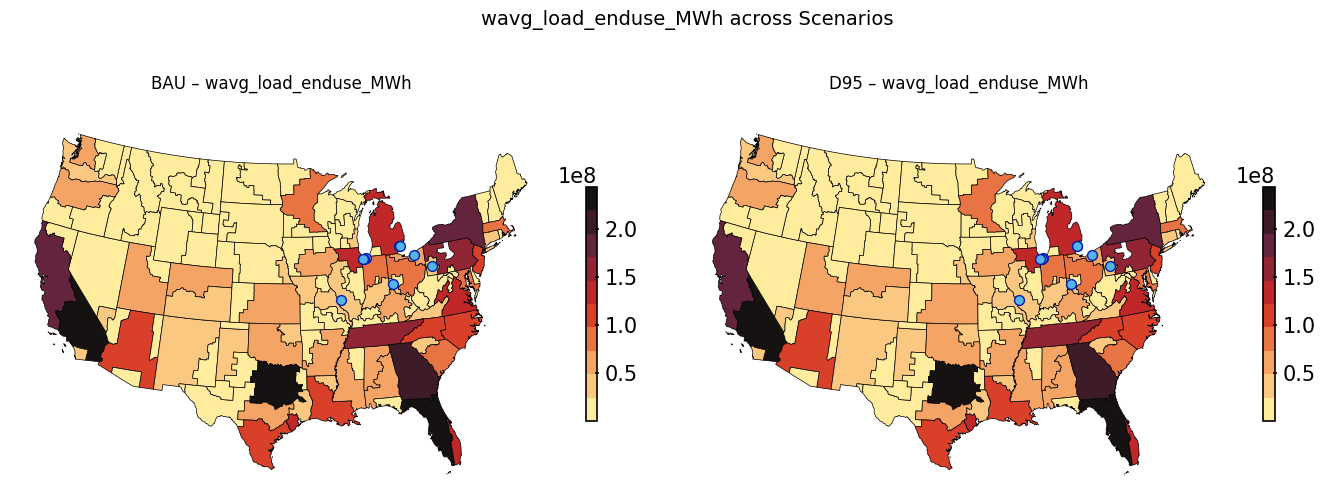

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


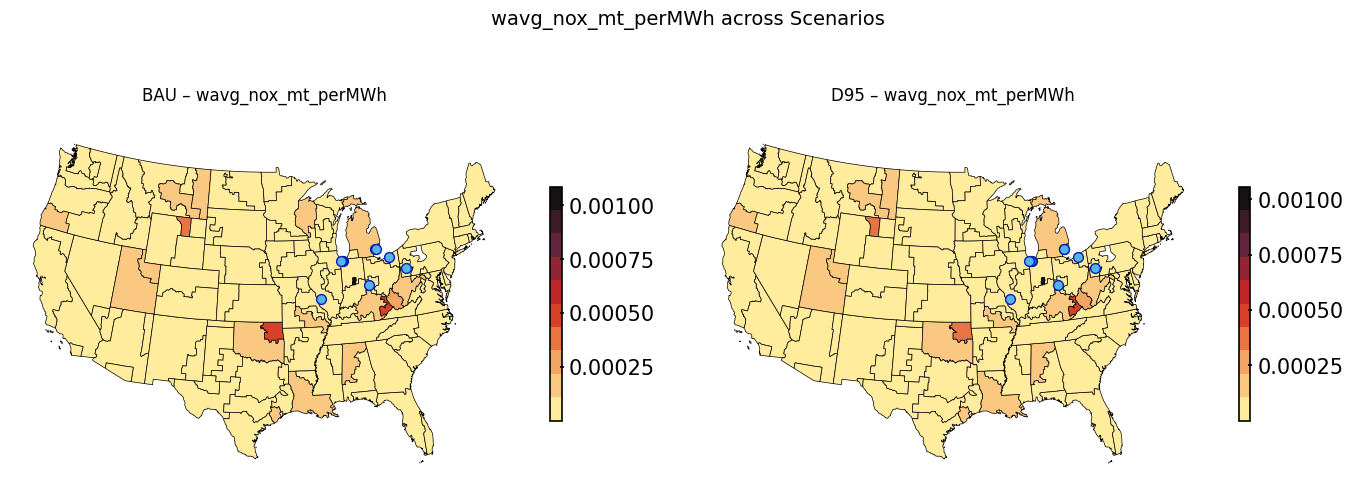

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


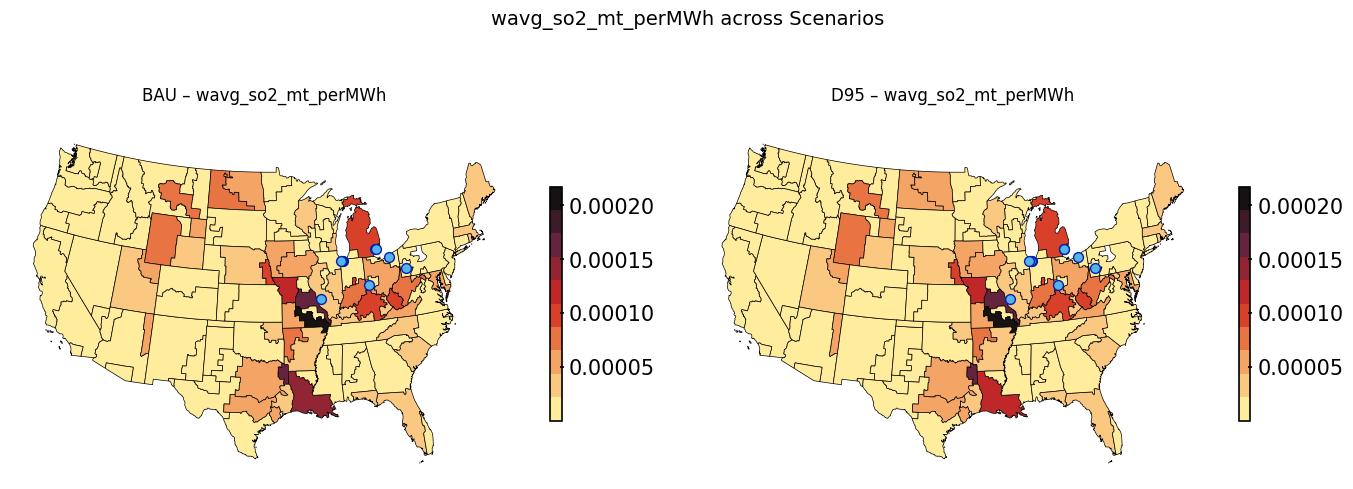

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:109: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


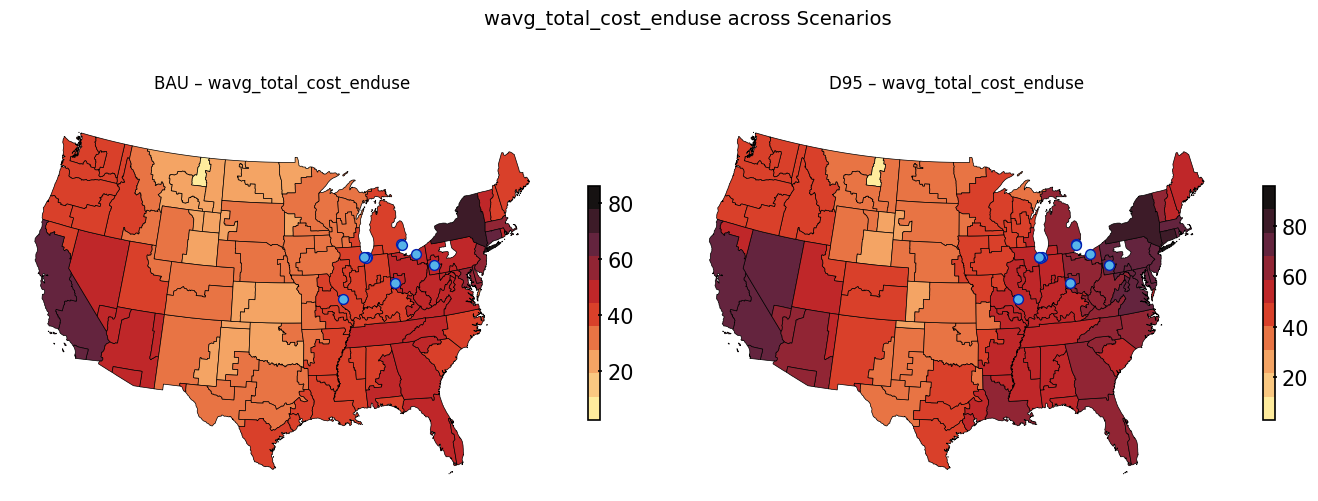

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


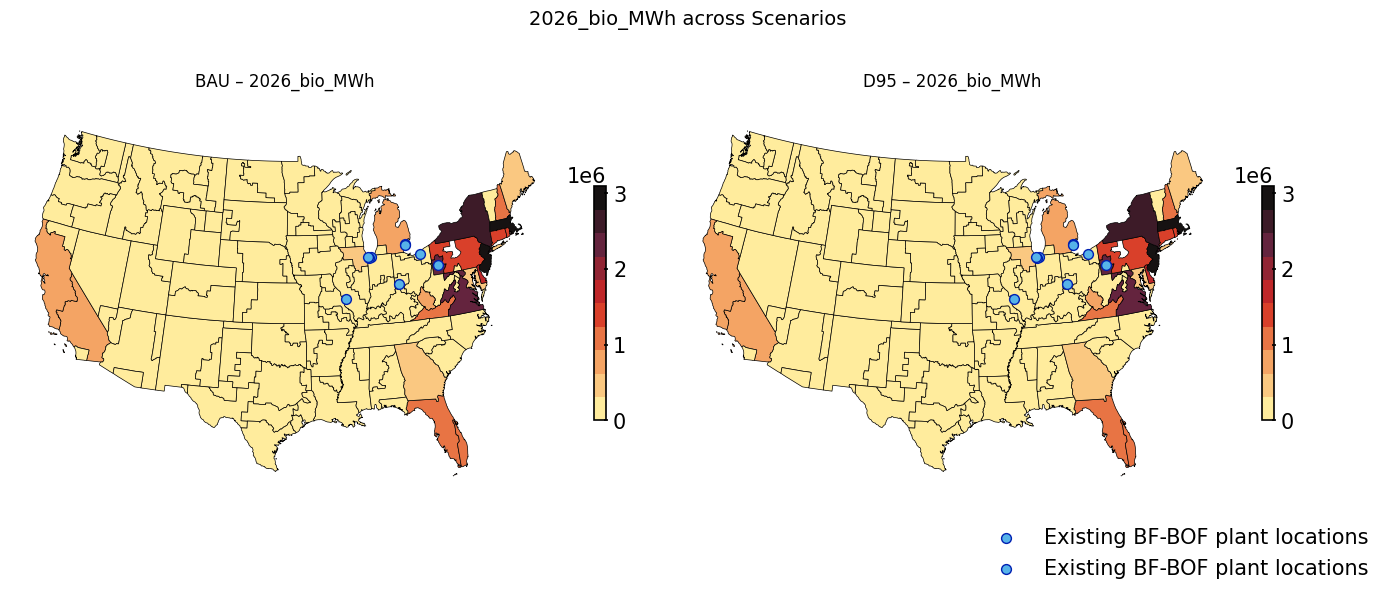

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


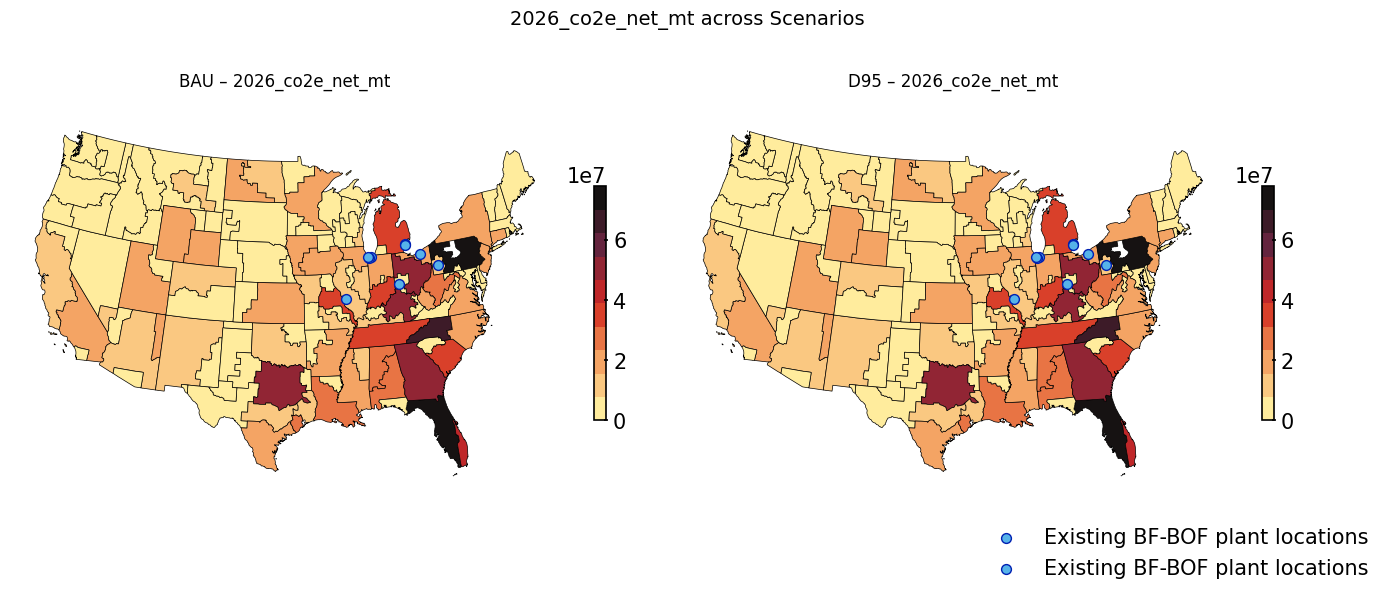

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


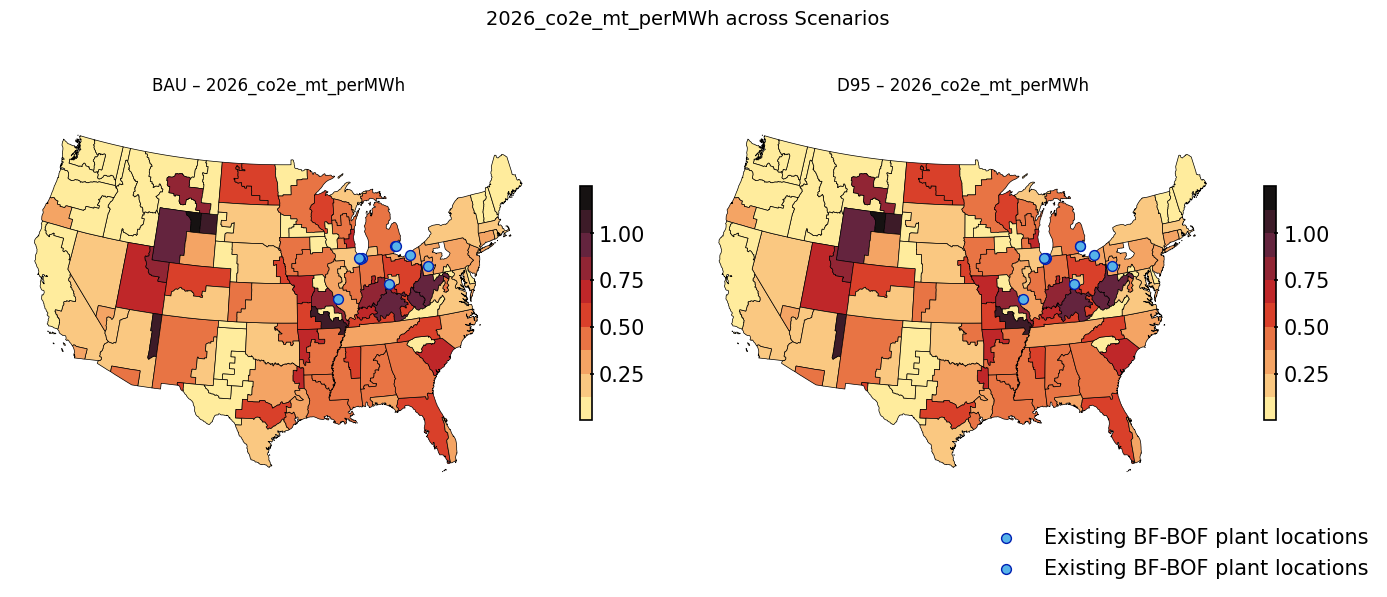

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


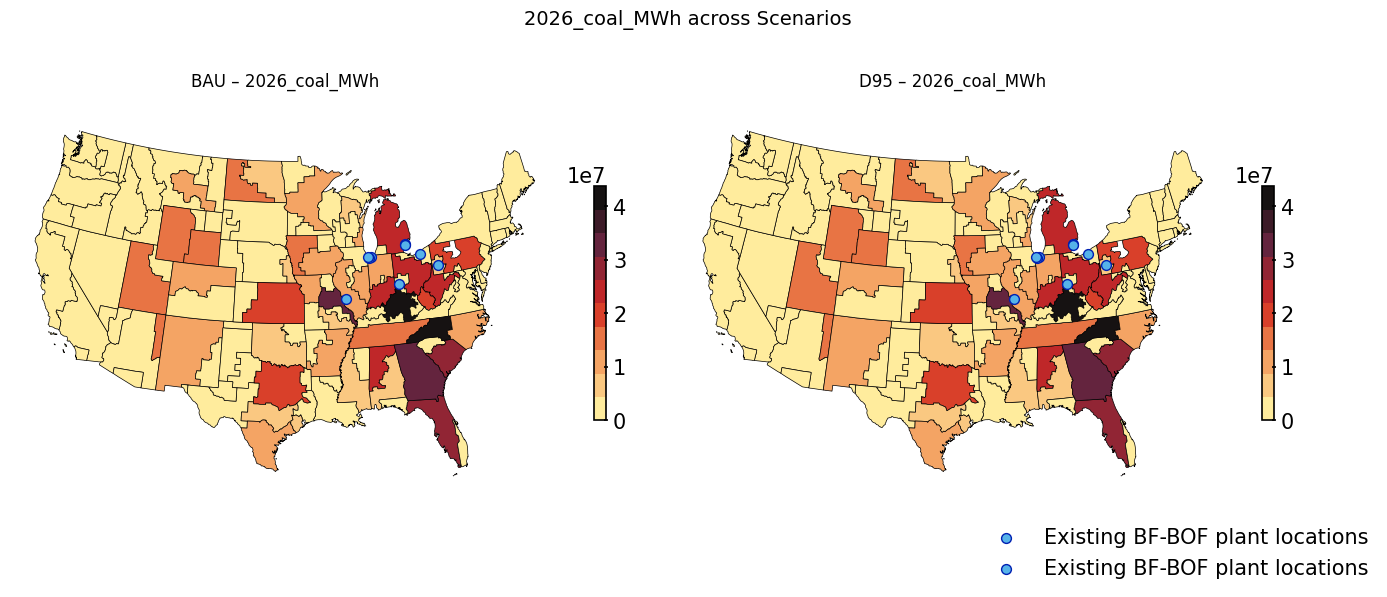

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


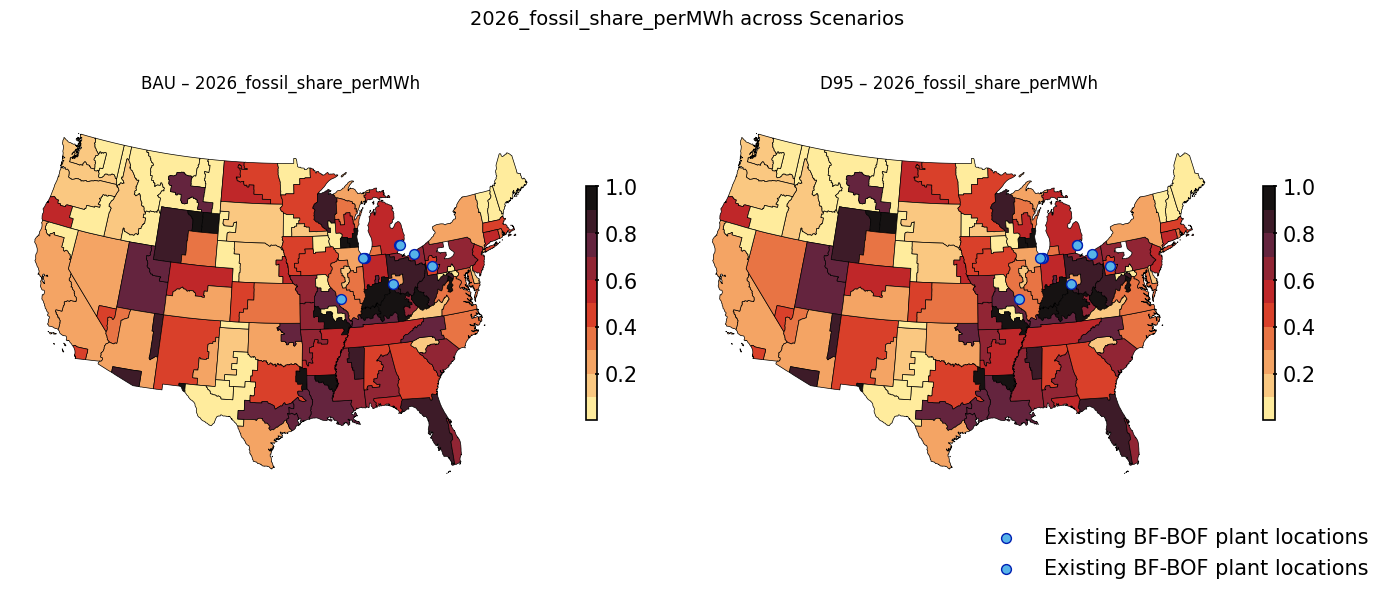

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


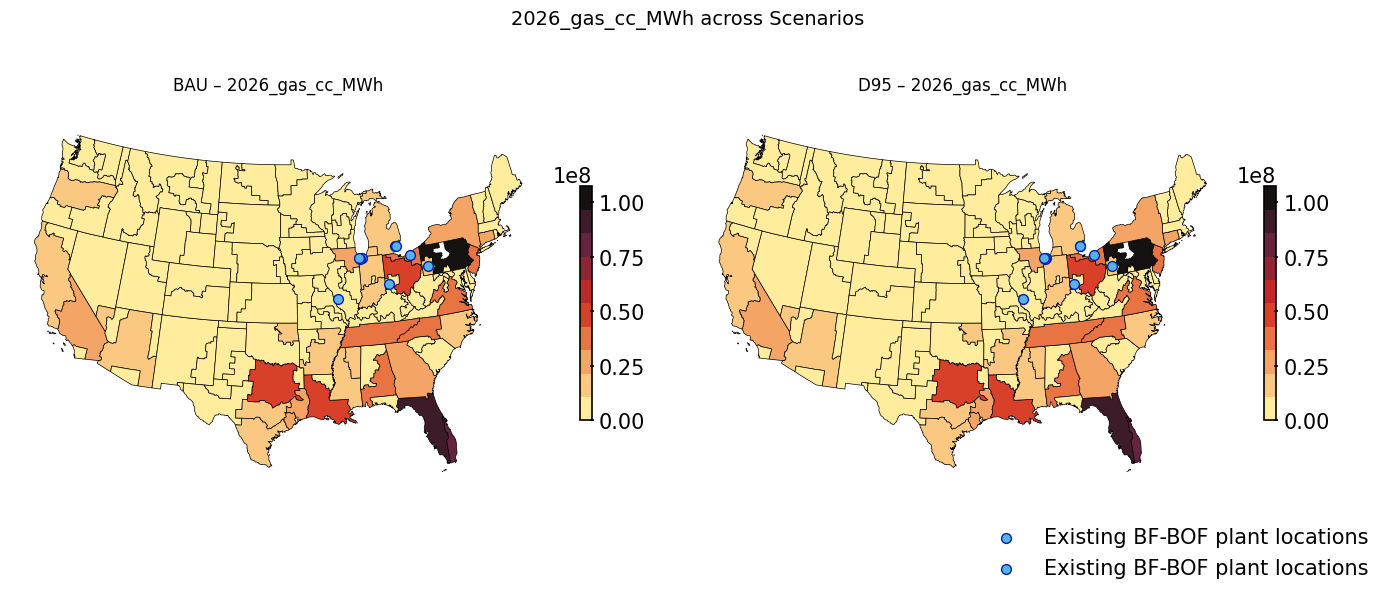

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


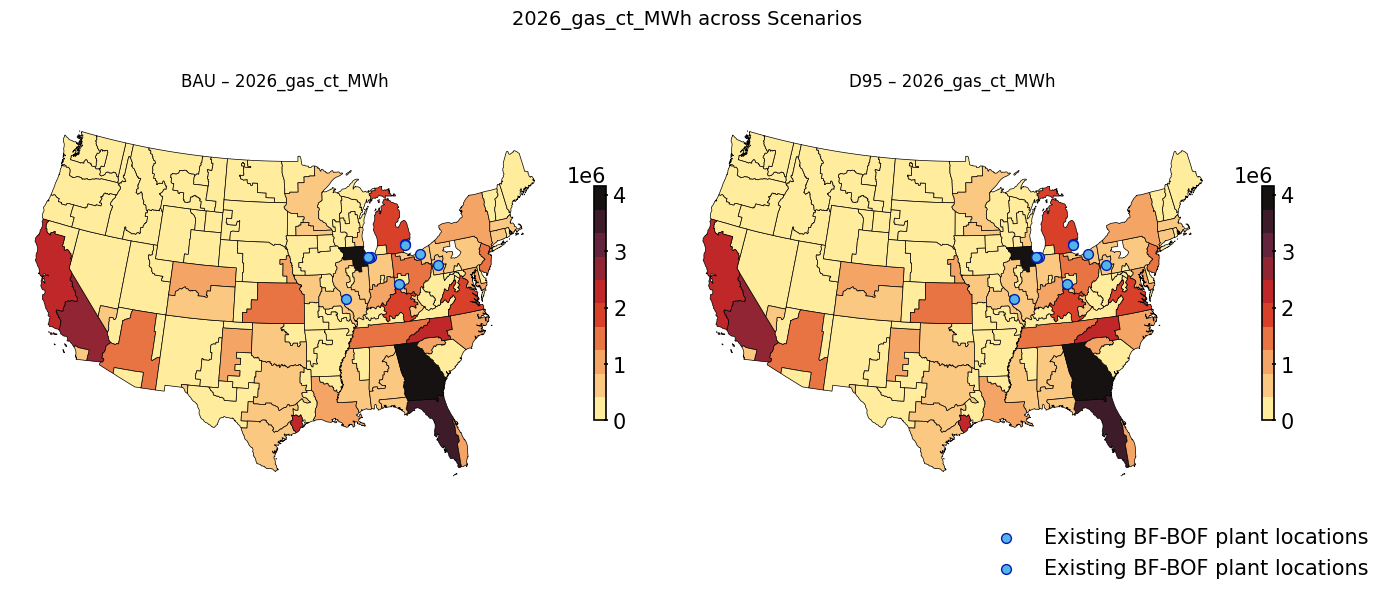

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


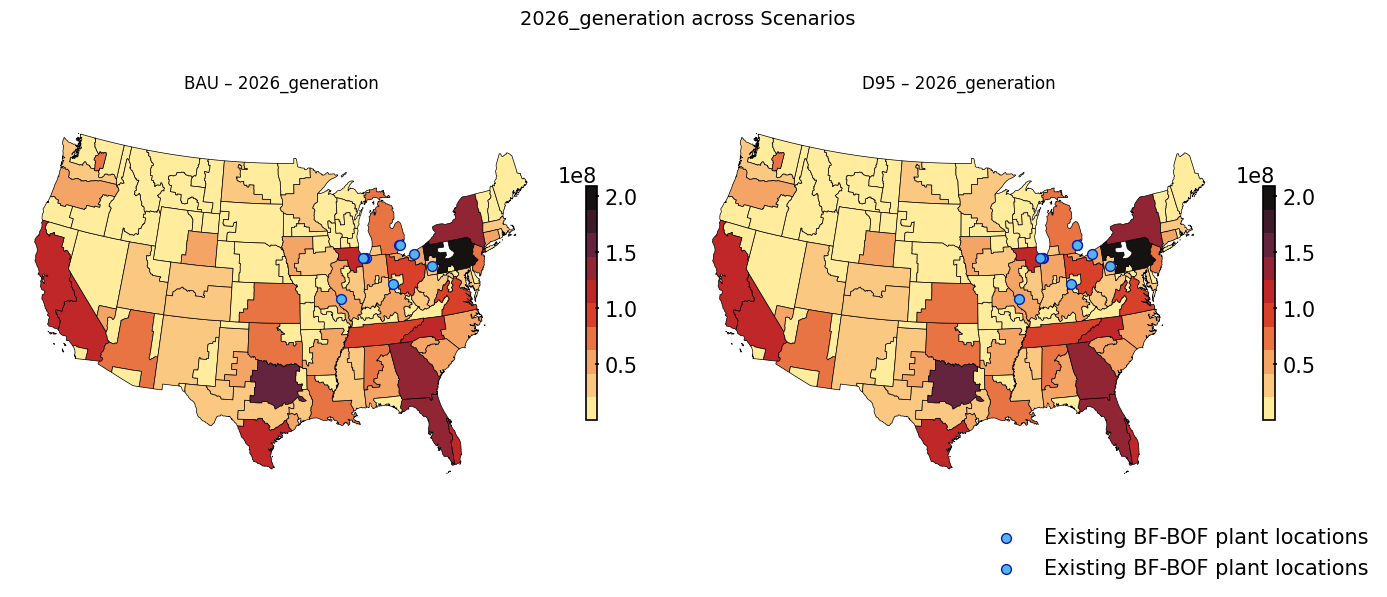

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


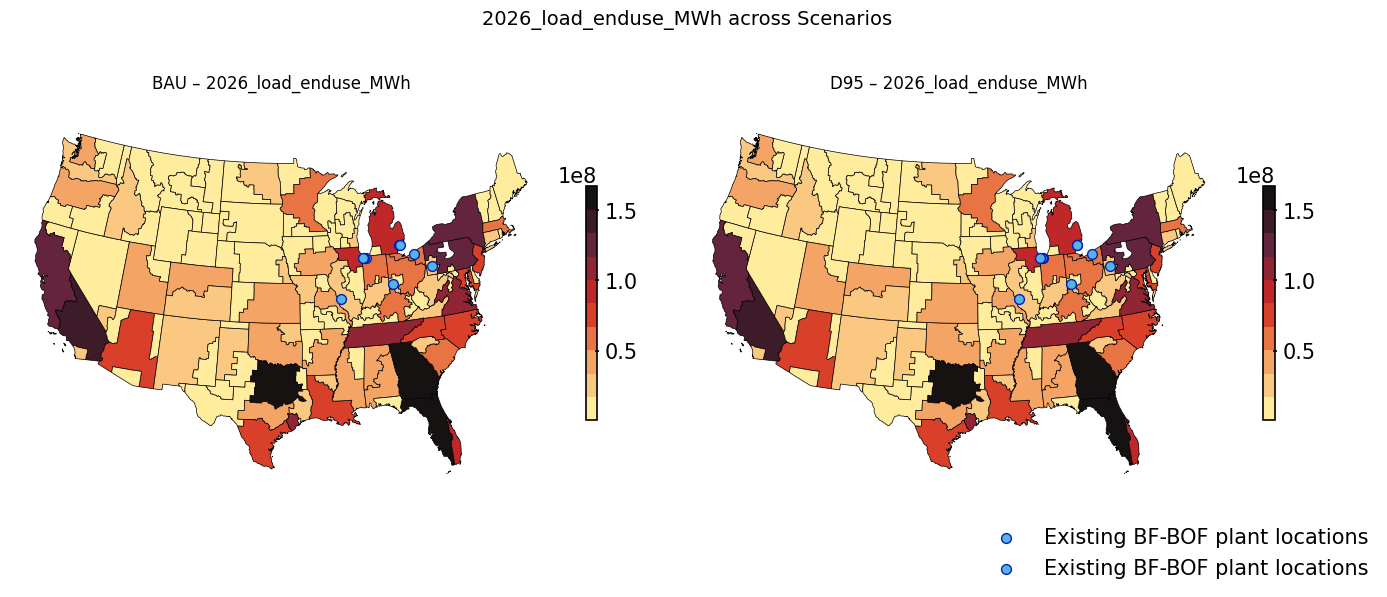

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


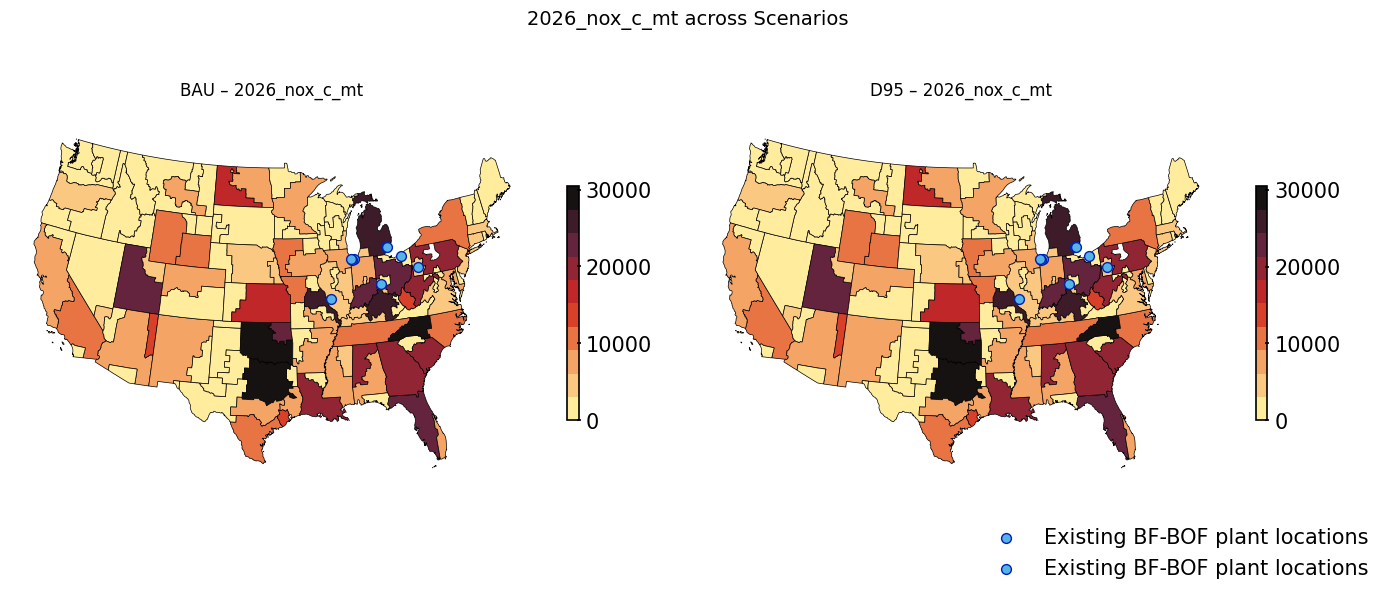

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


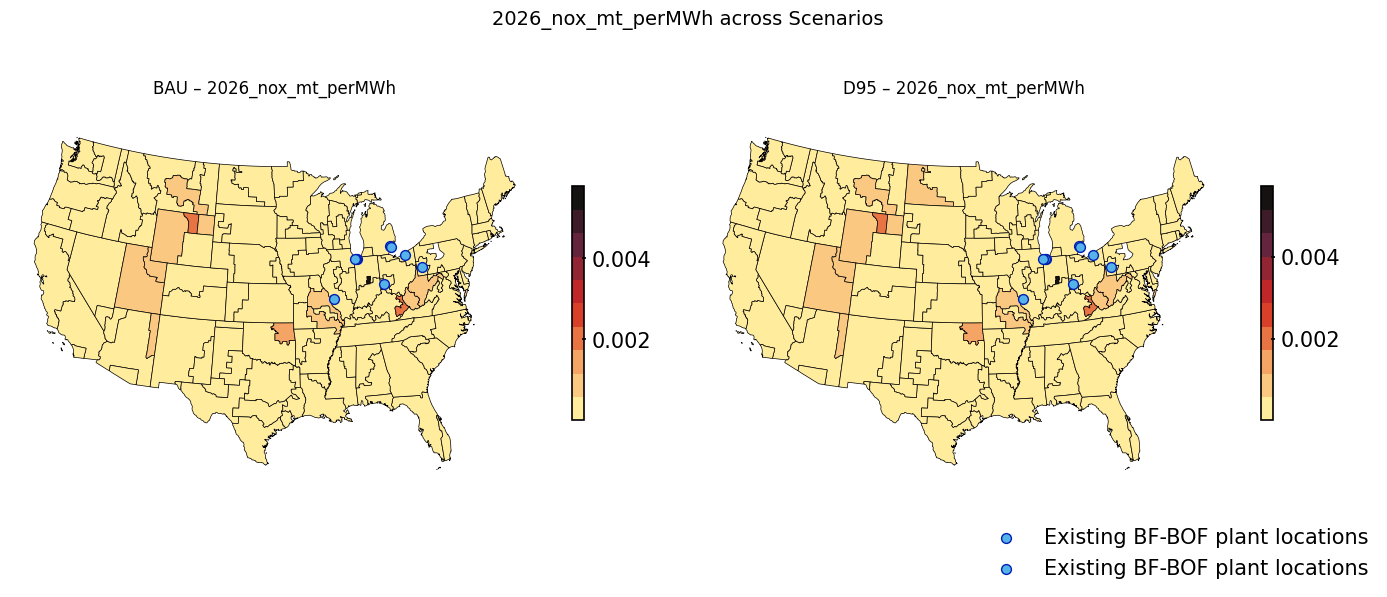

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


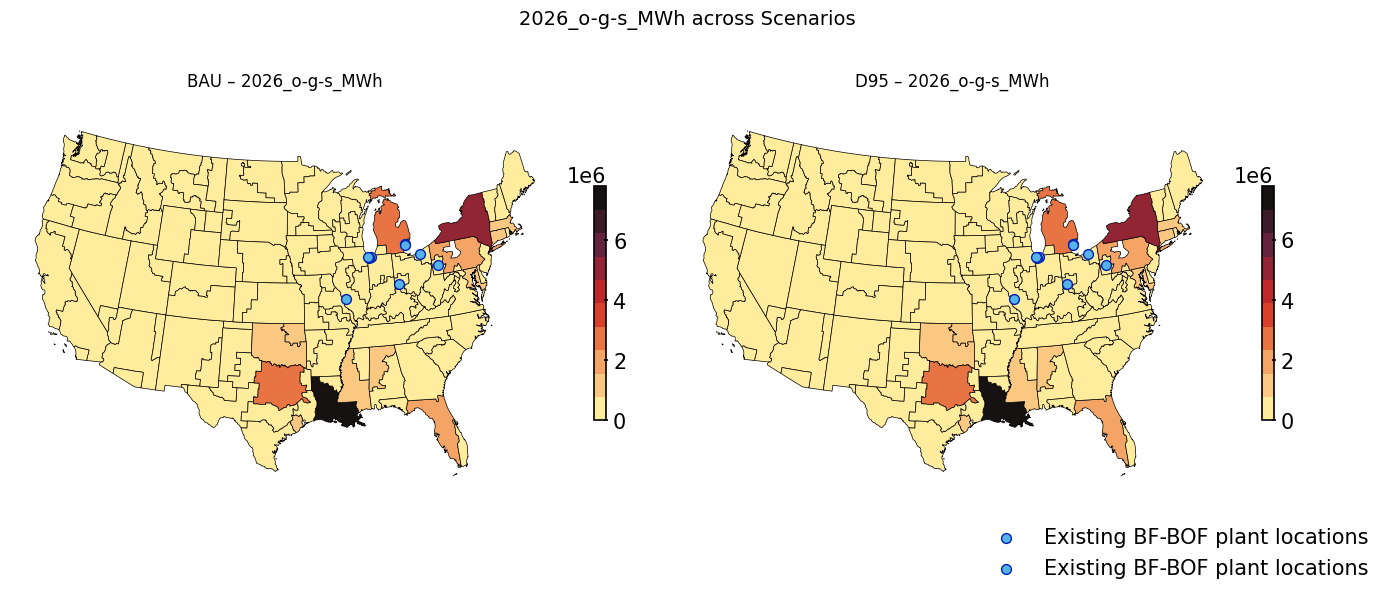

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


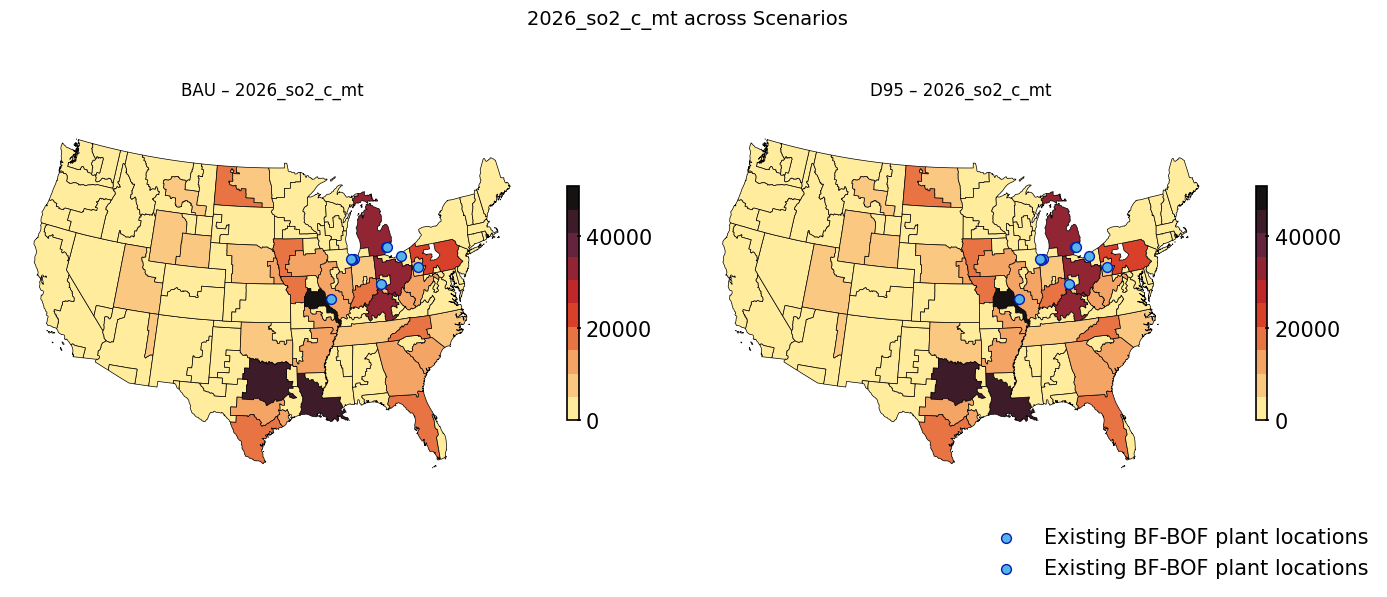

C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(
C:\Users\judec\AppData\Local\Temp\ipykernel_80808\693589519.py:215: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(


KeyboardInterrupt: 

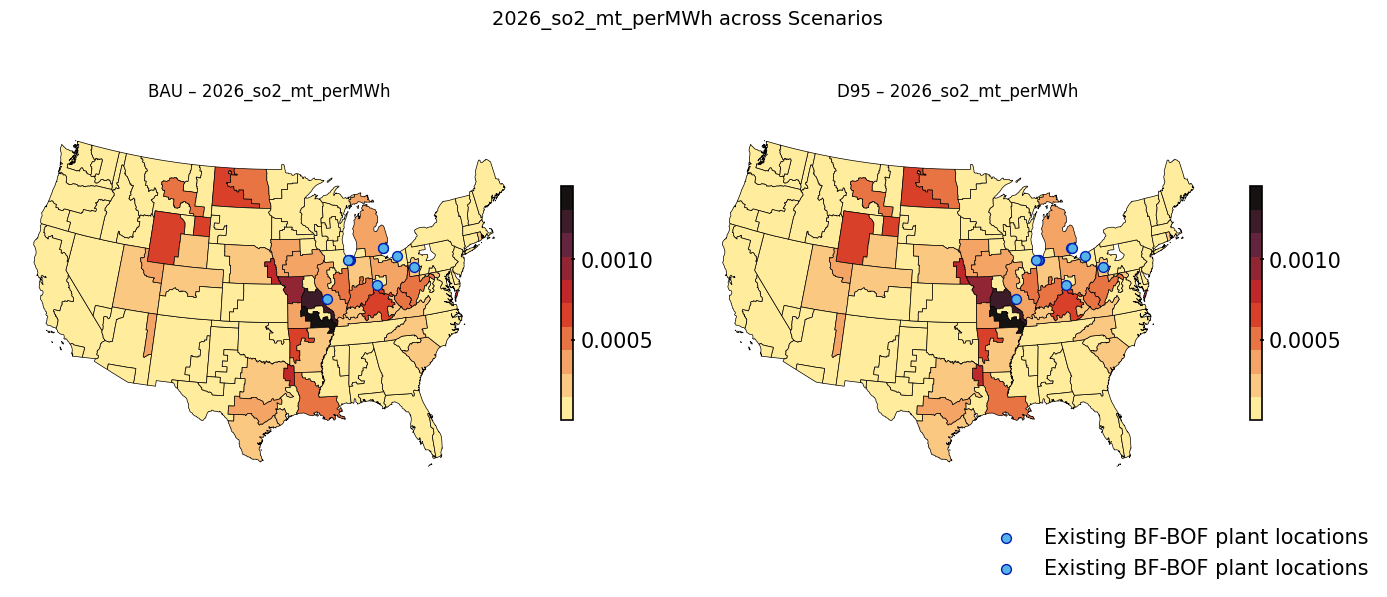

In [11]:
# PLOT MAP OF EMISSION FACTORS BY BA


scenarios = ['BAU', 'D95']

gdf = gpd.read_file("shapefiles/ReEDS BA/US_PCA.shp")
gdf.rename(columns={'rb': 'r'}, inplace=True)
gdf = gdf.sort_values(by='r').reset_index(drop=True)
gdf = gdf[gdf['r'] != 'p119'].copy()  # Exclude p119

# Define colors for site types
marker_colors = {'coke': 'magenta', 'IIS': "#56B3E9"}

# define colormap

from matplotlib.colors import ListedColormap, Normalize

# --- Extract hex codes (exclude the '23' prefix) ---

colors = ['#FFEC9D', '#FAC881', '#F4A464', '#E87444', '#D9402A', '#BF2729', '#912534', '#64243E', '#3D1B28', '#161212']

cmap_exter = ListedColormap(colors)




##############################################


# Loop through wavg columns
example_scenario = scenarios[0]
common_cols = [col for col in stdscen_allBAs[example_scenario].columns if col.startswith("wavg_")]

for base_col in common_cols:
    fig, axes = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(14, 6))
    if len(scenarios) == 1:
        axes = [axes]

    # Global min/max for consistent color scale
    all_values = pd.concat([
        stdscen_allBAs[scenario][base_col] for scenario in scenarios
    ]).dropna()

    # Mask out values that are <= 0 to avoid log scale issues
    all_values = all_values[all_values > 0]

    global_min = all_values.min()
    global_max = all_values.max()

    for i, scenario in enumerate(scenarios):
        df_vals = stdscen_allBAs[scenario]
        df_subset = df_vals[['r', base_col]].copy()
        colname = f"{scenario}_{base_col}"
        df_subset.rename(columns={base_col: colname}, inplace=True)

        # Merge value column into GeoDataFrame
        gdf_temp = gdf.merge(df_subset, on='r', how='left')

        # Mask non-positive values to avoid log errors
        gdf_temp[colname] = gdf_temp[colname].apply(lambda x: x if x > 0 else 1e-6)

        # Compute min/max from this column only (ignoring NaN)
        col_data = gdf_temp[colname].dropna()
        if col_data.empty:
            print(f"Skipping {colname} — no valid positive values")
            continue  # Skip empty column

        global_min = col_data.min()
        global_max = col_data.max()

        # Plot with log color scale
        gdf_temp.plot(
            column=colname,
            cmap=cmap_exter,
            linewidth=0.5,
            edgecolor='black',
            legend=True,
            ax=axes[i],
            #norm=LogNorm(vmin=global_min, vmax=global_max),
            vmin=global_min,  
            vmax=global_max,
            legend_kwds={'shrink': 0.5}
        )

        # === Overlay facility markers ===


        plant_df = stdscen[scenario].dropna(subset=['site latitude', 'site longitude', 'source type'])

        # PLOT IIS PLANTS ONLY AND RENAME
        plant_df = plant_df[plant_df['source type']=='IIS']

        from shapely.geometry import Point

        # Create GeoDataFrame for facility points
        geometry = [Point(xy) for xy in zip(plant_df['site longitude'], plant_df['site latitude'])]
        facilities_gdf = gpd.GeoDataFrame(plant_df, geometry=geometry, crs='EPSG:4326')

        # Reproject to match the shapefile's CRS
        facilities_gdf = facilities_gdf.to_crs(gdf_temp.crs)

        
#       print(f"All facilities in {scenario}: {len(plant_df)}")
#       print(plant_df[['site latitude', 'site longitude', 'source type']].head())
        
        for source_type in marker_colors.keys():
            subset = facilities_gdf[facilities_gdf['source type'] == source_type]

            subset.plot(
                ax=axes[i],
                markersize=50,
                color=marker_colors[source_type],
                edgecolor='#0020B2',
                linewidth=1,
                alpha=1,
                label="Existing BF-BOF plant locations"
            )

        axes[i].set_title(f"{scenario} – {base_col}", fontsize=12)
        axes[i].axis('off')

    """     # Add one shared legend for marker colors
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          label=label.upper(),
                          markerfacecolor=color, markersize=8)
               for label, color in marker_colors.items()]
    fig.legend(handles=handles, loc='upper right', ncol=len(marker_colors)) """

    plt.suptitle(f"{base_col} across Scenarios", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.1)
    plt.show()


######################################################################################################################

# Loop through 2026 columns
example_scenario = scenarios[0]
common_cols = [col for col in stdscen_allBAs[example_scenario].columns if col.startswith("2026_")]

for base_col in common_cols:
    fig, axes = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(14, 6))
    if len(scenarios) == 1:
        axes = [axes]

    # Global min/max for consistent color scale
    all_values = pd.concat([
        stdscen_allBAs[scenario][base_col] for scenario in scenarios
    ]).dropna()

    # Mask out values that are <= 0 to avoid log scale issues
    all_values = all_values[all_values > 0]

    global_min = all_values.min()
    global_max = all_values.max()

    for i, scenario in enumerate(scenarios):
        df_vals = stdscen_allBAs[scenario]
        df_subset = df_vals[['r', base_col]].copy()
        colname = f"{scenario}_{base_col}"
        df_subset.rename(columns={base_col: colname}, inplace=True)

        # Merge value column into GeoDataFrame
        gdf_temp = gdf.merge(df_subset, on='r', how='left')

        # Mask non-positive values to avoid log errors
        gdf_temp[colname] = gdf_temp[colname].apply(lambda x: x if x > 0 else 1e-6)

        # Compute min/max from this column only (ignoring NaN)
        col_data = gdf_temp[colname].dropna()
        if col_data.empty:
            print(f"Skipping {colname} — no valid positive values")
            continue  # Skip empty column

        global_min = col_data.min()
        global_max = col_data.max()

        # Plot with log color scale
        gdf_temp.plot(
            column=colname,
            cmap=cmap_exter,
            linewidth=0.5,
            edgecolor='black',
            legend=True,
            ax=axes[i],
            #norm=LogNorm(vmin=global_min, vmax=global_max),
            vmin=global_min,    # optional: set linear range explicitly
            vmax=global_max,
            legend_kwds={'shrink': 0.5}
        )

        # === Overlay facility markers ===

        plant_df = stdscen[scenario].dropna(subset=['site latitude', 'site longitude', 'source type'])

        # PLOT IIS PLANTS ONLY AND RENAME
        plant_df = plant_df[plant_df['source type']=='IIS']

        

        # Create GeoDataFrame for facility points
        geometry = [Point(xy) for xy in zip(plant_df['site longitude'], plant_df['site latitude'])]
        facilities_gdf = gpd.GeoDataFrame(plant_df, geometry=geometry, crs='EPSG:4326')

        # Reproject to match the shapefile's CRS
        facilities_gdf = facilities_gdf.to_crs(gdf_temp.crs)

        
#       print(f"All facilities in {scenario}: {len(plant_df)}")
#       print(plant_df[['site latitude', 'site longitude', 'source type']].head())
        
        for source_type in marker_colors.keys():
            subset = facilities_gdf[facilities_gdf['source type'] == source_type]

            subset.plot(
                ax=axes[i],
                markersize=50,
                color=marker_colors[source_type],
                edgecolor='#0020B2',
                linewidth=1,
                alpha=1,
                label="Existing BF-BOF plant locations"
            )

        axes[i].set_title(f"{scenario} – {base_col}", fontsize=12)
        axes[i].axis('off')

    # --- Add one shared legend to the figure ---
    fig.legend(

        loc='lower right',
        frameon=False        # cleaner look
    )

    plt.suptitle(f"{base_col} across Scenarios", fontsize=14)



    fig.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.1)
    out_dir = r"C:\Users\judec\Documents\CMU\Project 1\Final Figures"
    png_path = fr"{out_dir}\cambiumMap_{base_col}_across_Scenarios.png"
    #pdf_path = fr"{out_dir}\cambiumMap_{base_col}_across_Scenarios.pdf"

    # Force a render, then save this *specific* figure
    fig.canvas.draw()         # (defensive; helps with tight bbox/annotations)
    fig.savefig(png_path, dpi=600, bbox_inches="tight")
    #fig.savefig(pdf_path, dpi=300, bbox_inches="tight")

    plt.show()



['pillow', 'ffmpeg', 'ffmpeg_file', 'html']
Saved animation: C:\Users\judec\Documents\CMU\Project 1\Final Figures\cambiumMap_BAU_CO2e_Animation.mp4


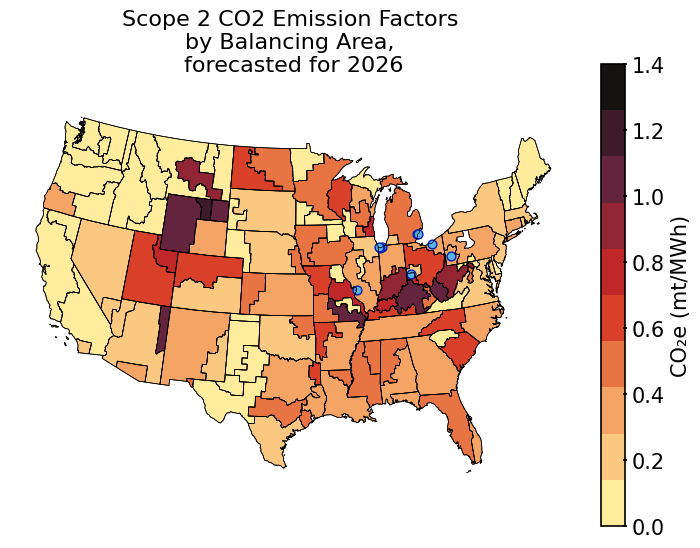

In [15]:
# CREATE ANIMATION FOR CO2 EFS
import os, sys

ffmpeg_bin = r"C:\ffmpeg\bin"          # adjust if different
os.environ["PATH"] = ffmpeg_bin + os.pathsep + os.environ.get("PATH", "")

import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


print(animation.writers.list())


# ---------- CONFIG ----------
scenario = 'BAU'  # <- change to 'D95' if desired
years = list(range(2026, 2051, 3))  # 2026, 2029, ..., 2062
col_suffix = "co2e_mt_perMWh"
vmin, vmax = 0.0, 1.4
out_dir = r"C:\Users\judec\Documents\CMU\Project 1\Final Figures"
animation_path = fr"{out_dir}\cambiumMap_{scenario}_CO2e_Animation.mp4"
fps = 0.75   # 1 frame per second (tweak if you like)

# ---------- OPTIONAL: overlay IIS facilities (static) ----------
show_facilities = True
fac_color = "#56B3E9"
fac_edge = "#0020B2"
fac_size = 40

if show_facilities:
    # build once; reproject to the map's CRS
    from shapely.geometry import Point
    plant_df = stdscen[scenario].dropna(subset=['site latitude','site longitude','source type'])
    plant_df = plant_df[plant_df['source type'] == 'IIS'].copy()
    fac_geom = [Point(xy) for xy in zip(plant_df['site longitude'], plant_df['site latitude'])]
    facilities_gdf = gpd.GeoDataFrame(plant_df, geometry=fac_geom, crs='EPSG:4326').to_crs(gdf.crs)

# ---------- FIGURE / COLORBAR ----------
fig, ax = plt.subplots(figsize=(8, 6))

# draw BA boundaries once beneath polygons
gdf.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')

norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap=cmap_exter)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("CO₂e (mt/MWh)")

ax.set_axis_off()

# ---------- UPDATE FUN ----------
def draw_frame(year):
    ax.clear()
    # redraw boundary each frame (simple + robust)
    gdf.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')
    ax.set_axis_off()

    base_col = f"{year}_{col_suffix}"
    if base_col not in stdscen_allBAs[scenario].columns:
        ax.set_title(f"{scenario} – {base_col} (missing)", fontsize=12)
        return

    df_vals = stdscen_allBAs[scenario][['r', base_col]].copy()
    df_vals.rename(columns={base_col: 'value'}, inplace=True)

    gdf_temp = gdf.merge(df_vals, on='r', how='left')

    # ensure numeric; clip to fixed range [vmin, vmax]
    gdf_temp['value'] = pd.to_numeric(gdf_temp['value'], errors='coerce')
    gdf_temp['value'] = gdf_temp['value'].clip(lower=vmin, upper=vmax)

    # polygon fill for this frame
    gdf_temp.plot(
        column='value',
        cmap=cmap_exter,
        vmin=vmin, vmax=vmax,
        linewidth=0.5,
        edgecolor='black',
        ax=ax,
        legend=False  # we use the fixed colorbar above
    )

    # static facility overlay (optional)
    if show_facilities and len(facilities_gdf) > 0:
        facilities_gdf.plot(
            ax=ax, markersize=fac_size, color=fac_color,
            edgecolor=fac_edge, linewidth=1.0, alpha=1.0
        )

    ax.set_title(f"Scope 2 CO2 Emission Factors \nby Balancing Area, \nforecasted for {year}", fontsize=16)

def init():
    draw_frame(years[0])
    return []

def update(frame_year):
    draw_frame(frame_year)
    return []

anim = FuncAnimation(
    fig, update, frames=years, init_func=init,
    interval=int(1000 / fps), blit=False, repeat=True
)

# Save mp4
anim.save(animation_path, writer='ffmpeg', fps=fps, dpi=300)
print(f"Saved animation: {animation_path}")


In [19]:
print(stdscen['BAU'])

# Extract the relevant DataFrame
df = stdscen['BAU']

# Define columns
value_cols = ['wavg_total_cost_enduse', 'wavg_co2e_mt_perMWh']
weight_col = 'steel prod mt/y'

# Drop rows with missing weights or values
df_valid = df.dropna(subset=value_cols + [weight_col])

# Compute weighted averages
weighted_avgs = {
    col: (df_valid[col] * df_valid[weight_col]).sum() / df_valid[weight_col].sum()
    for col in value_cols
}

print(weighted_avgs)

   source type                                      parent IIS  fips code  \
0          IIS                       AK STEEL - DEARBORN WORKS      26163   
1          IIS                     U S STEEL GREAT LAKES WORKS      26163   
2          IIS               AK Steel Corporation (1409010006)      39017   
3          IIS                  ArcelorMittal Burns Harbor LLC      18127   
4          IIS        ArcelorMittal Cleveland LLC (1318001613)      39035   
5          IIS                           US STEEL   GARY WORKS      18089   
6          IIS                           ARCELORMITTAL USA LLC      18089   
7          IIS  Granite City Works of United States Steel Corp      17119   
8          IIS                    USS CORP/EDGAR THOMSON WORKS      42003   
9         coke                                             NaN       1073   
10        coke                                             NaN      51027   
11        coke                                             NaN      54009   

In [20]:


# Extract the relevant DataFrame
df = stdscen['D95']

# Define columns
value_cols = ['wavg_total_cost_enduse', 'wavg_co2e_mt_perMWh']
weight_col = 'steel prod mt/y'

# Drop rows with missing weights or values
df_valid = df.dropna(subset=value_cols + [weight_col])

# Compute weighted averages
weighted_avgs = {
    col: (df_valid[col] * df_valid[weight_col]).sum() / df_valid[weight_col].sum()
    for col in value_cols
}

print(weighted_avgs)

{'wavg_total_cost_enduse': np.float64(59.9570136190595), 'wavg_co2e_mt_perMWh': np.float64(0.12587111161769501)}
